# Doc embedding evaluation (315 repositories / train set)

## 1. Loading repository information

In [1]:
!pip install gdown
!gdown 1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756

Downloading...
From (uriginal): https://drive.google.com/uc?id=1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756
From (redirected): https://drive.google.com/uc?id=1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756&confirm=t&uuid=57429c8c-15e6-4af4-963e-3cbe37297007
To: /cs/home/hz65/PycharmProjects/PythonSimilarity/Embedding/Embedding_model_315/Doc_embedding_evaluation_315/repo_info.pkl
100%|████████████████████████████████████████| 201M/201M [00:02<00:00, 96.6MB/s]


In [2]:
import pickle

with open("repo_info_train.pkl", "rb") as f:
    repo_info = pickle.load(f)
    f.close()

## 2. Download pre-trained model

In [3]:
!pip3 install torch
!pip3 install transformers
!pip3 install sentence-transformers
# !wget https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
!curl -O https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10352  100 10352    0     0   168k      0 --:--:-- --:--:-- --:--:--  171k


In [4]:
import torch

# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
device = "cpu"
print(device)

cpu


In [5]:
unixcoder_model_names = [
    "microsoft/unixcoder-base-nine",
    "microsoft/unixcoder-base",
    "microsoft/unixcoder-base-unimodal",
    "Lazyhope/unixcoder-nine-advtest",
    "Lazyhope/unixcoder-clone-detection",
    "Enoch/Unixcoder-Tuned-Code-Search-Py"
]
sentence_transformer_model_names = [
    "sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/multi-qa-mpnet-base-cos-v1",
    "sentence-transformers/bert-base-nli-mean-tokens",
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    "sentence-transformers/all-distilroberta-v1",
    "sentence-transformers/distilbert-base-nli-mean-tokens"
]

In [6]:
from unixcoder import UniXcoder
from sentence_transformers import SentenceTransformer

unixcoder_models = {}
sentence_transformer_models = {}

# Initialise unixcoder model
for u_name in unixcoder_model_names:
    unixcoder_models[u_name] = UniXcoder(u_name)
    unixcoder_models[u_name].to(device)

# Initialise sentence transformer model
for s_name in sentence_transformer_model_names:
    sentence_transformer_models[s_name] = SentenceTransformer(model_name_or_path=s_name, device=device)

/cs/home/hz65/python/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Generating doc embeddings

In [7]:
# Getting code embeddings
def get_code_embeddings(code, model):
    tokens_ids = model.tokenize([code], max_length=512, mode="<encoder-only>")
    source_ids = torch.tensor(tokens_ids).to(device)
    _, embeddings = model(source_ids)
    return embeddings

# Getting other embbeddings
def get_other_embeddings(data_list):
    embeddings = {}
    
    # Unixcoder model
    for u_name, u_model in tqdm(unixcoder_models.items()):
        print(f" - Using {u_name} model - ")
        embeddings_list = torch.concat([get_code_embeddings(code, u_model) for code in data_list])
        embeddings[u_name] = torch.mean(embeddings_list, dim=0)
        # embeddings[u_name] = embeddings_list
    
    # Sentence transformer model
    for s_name, s_model in tqdm(sentence_transformer_models.items()):
        print(f" - Using {s_name} model - ")
        embeddings_list = s_model.encode(data_list, convert_to_tensor=True)
        embeddings[s_name] = torch.mean(embeddings_list, dim=0)
        # embeddings[s_name] = embeddings_list
    
    return embeddings


# Getting embeddings
def get_embeddings(input_data=None, input_mode=None):
    if input_data is None or not input_data:
        return torch.zeros((768,), device=device)
    
    with torch.no_grad():
        if input_mode == "docs":
            return get_other_embeddings(input_data)


In [8]:
from tqdm import tqdm

for repo_name, repo_dict in tqdm(repo_info.items()):
    print(f" - Generating doc embeddings for {repo_name} - ")
    repo_dict["docs_embeddings"] = get_embeddings(input_data=repo_dict["docs"], input_mode="docs")

  0%|                                                   | 0/315 [00:00<?, ?it/s]

 - Generating doc embeddings for jet-admin/jet-bridge - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.99it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 14.04it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 13.32it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 13.90it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



  0%|▏                                          | 1/315 [00:00<04:31,  1.16it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for patrys/httmock - 
 - Generating doc embeddings for pytransitions/transitions - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.61s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.61s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.61s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.60s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.61s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.61s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.32s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:31,  7.83s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:15,  5.10s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:07,  3.85s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.00s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  1%|▍                                        | 3/315 [00:34<1:06:18, 12.75s/it]

 - Generating doc embeddings for keleshev/schema - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.36it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.35it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.36it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.31it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.32it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.33it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.45it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.45it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.46it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.33it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.38it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  1%|▌                                          | 4/315 [00:41<54:53, 10.59s/it]

 - Generating doc embeddings for dylanaraps/pywal - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.97s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.99s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.99s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.99s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.99s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.99s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.25it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.27it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.26it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.25it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.56it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  2%|▋                                        | 5/315 [00:57<1:03:45, 12.34s/it]

 - Generating doc embeddings for PyCQA/modernize - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.12it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.10it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.08it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.09it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.07it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.55it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.55it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.54it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.27it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



  2%|▊                                          | 6/315 [01:00<49:06,  9.54s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for jaraco/path.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.54it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.51it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.50it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.51it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.51it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.50it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.08s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.09s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.25it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.50it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.76it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  2%|▉                                          | 7/315 [01:05<41:43,  8.13s/it]

 - Generating doc embeddings for xonsh/xonsh - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:00, 12.13s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:24<00:48, 12.21s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:36<00:36, 12.22s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:48<00:24, 12.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:01<00:12, 12.21s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:13<00:00, 12.21s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:12<01:01, 12.34s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:24<00:49, 12.32s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:33<00:31, 10.62s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:42<00:20, 10.12s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:49<00:09,  9.11s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  3%|█                                        | 8/315 [03:13<3:51:00, 45.15s/it]

 - Generating doc embeddings for python-excel/xlrd - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.48it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.49it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.49it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.50it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.51it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.46it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.37it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.52it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.41it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  3%|█▏                                       | 9/315 [03:17<2:45:33, 32.46s/it]

 - Generating doc embeddings for cloudnativelabs/kube-shell - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.90it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  7.02it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  7.03it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.98it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 15.96it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



  3%|█▎                                      | 10/315 [03:18<1:56:33, 22.93s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for ironmussa/Optimus - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:00, 12.10s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:24<00:48, 12.14s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:36<00:36, 12.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:48<00:24, 12.12s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:00<00:12, 12.12s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:12<00:00, 12.13s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:09<00:48,  9.68s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:19<00:38,  9.72s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:26<00:25,  8.40s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:33<00:15,  7.92s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:38<00:06,  6.84s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  3%|█▍                                      | 11/315 [05:13<4:17:14, 50.77s/it]

 - Generating doc embeddings for jazzband/django-taggit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.74it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.76it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.76it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.77it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.77it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.77it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.37s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.37s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.37s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.39s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.15s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  4%|█▌                                      | 12/315 [05:23<3:14:41, 38.55s/it]

 - Generating doc embeddings for moggers87/salmon - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.33s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.32s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.43s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.38s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:05,  5.35s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:32<00:00,  5.35s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.42s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.44s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:15,  5.32s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:09,  4.81s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:24<00:04,  4.55s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  4%|█▋                                      | 13/315 [06:22<3:45:21, 44.77s/it]

 - Generating doc embeddings for glamp/bashplotlib - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.87it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  7.53it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  7.72it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.52it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 16.29it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



  4%|█▊                                      | 14/315 [06:23<2:38:37, 31.62s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for PyCQA/prospector - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.27s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.28s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.27s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.29s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.30s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.15s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.22s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.06s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  2.00s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.70s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  5%|█▉                                      | 15/315 [06:41<2:17:47, 27.56s/it]

 - Generating doc embeddings for twisted/treq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.26s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.28s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.27s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.28s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:05,  5.27s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:31<00:00,  5.27s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.62s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.62s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.41s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.38s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  3.62s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  5%|██                                      | 16/315 [07:35<2:56:40, 35.45s/it]

 - Generating doc embeddings for bbangert/beaker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.95s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.96s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.96s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.95s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.95s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.95s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.59s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:13<00:26,  6.69s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:13,  4.61s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:07,  3.63s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:03,  3.91s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  5%|██▏                                     | 17/315 [08:10<2:55:07, 35.26s/it]

 - Generating doc embeddings for pypa/bandersnatch - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.15it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.17it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.18it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.18it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.18it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.18it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.33it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.37it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.38it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.39it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.66it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  6%|██▎                                     | 18/315 [08:19<2:15:09, 27.30s/it]

 - Generating doc embeddings for zachwill/moment - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.74it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.75it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.76it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.76it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.77it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.76it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.80it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.87it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.89it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.66it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  6%|██▍                                     | 19/315 [08:24<1:41:49, 20.64s/it]

 - Generating doc embeddings for encode/apistar - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.92it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.92it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.92it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.92it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.92it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.92it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.17it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.18it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.19it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.25it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.56it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  6%|██▌                                     | 20/315 [08:31<1:21:37, 16.60s/it]

 - Generating doc embeddings for pyinvoke/invoke - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.46s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.47s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:19,  6.47s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:12,  6.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:32<00:06,  6.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:38<00:00,  6.47s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:09<00:45,  9.11s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:20<00:42, 10.68s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:25<00:23,  7.91s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:30<00:13,  6.61s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:35<00:06,  6.27s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  7%|██▋                                     | 21/315 [09:48<2:50:10, 34.73s/it]

 - Generating doc embeddings for skorokithakis/shortuuid - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.56it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.66it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.69it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.72it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.73it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.71it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.85it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.08it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.10it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.59it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  7%|██▊                                     | 22/315 [09:51<2:03:33, 25.30s/it]

 - Generating doc embeddings for s3tools/s3cmd - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.15it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.15it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.15it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.16it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.16it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.15it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.59s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.57s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.14s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.94s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.65s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  7%|██▉                                     | 23/315 [10:07<1:48:54, 22.38s/it]

 - Generating doc embeddings for pyenv/pyenv - 



 33%|███████████████                              | 2/6 [00:00<00:00, 13.73it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 13.50it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 13.50it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 14.05it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



  8%|███                                     | 24/315 [10:08<1:17:07, 15.90s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for stchris/untangle - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.93it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.91it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.89it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.90it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.90it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.90it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.30s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.30s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:02,  1.05it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.25it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.39it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  8%|███▏                                    | 25/315 [10:14<1:02:38, 12.96s/it]

 - Generating doc embeddings for nvdv/vprof - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.42s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.42s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.42s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.43s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.43s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.43s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.04it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.04it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.03it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.04it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.23it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  8%|███▎                                    | 26/315 [10:27<1:03:06, 13.10s/it]

 - Generating doc embeddings for h2oai/h2o-3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:33<02:46, 33.33s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:07<02:15, 33.95s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:41<01:41, 33.86s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:14<01:07, 33.70s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:48<00:33, 33.62s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [03:21<00:00, 33.66s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:35<02:58, 35.67s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [01:13<02:27, 36.99s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:42<01:40, 33.46s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [02:12<01:03, 31.95s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:30<00:27, 27.04s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  9%|███▎                                   | 27/315 [16:34<9:32:58, 119.37s/it]

 - Generating doc embeddings for benhamner/Metrics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.03s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.01s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.00s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.00s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.01s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.47s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.48s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.08s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.91s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.75s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  9%|███▌                                    | 28/315 [16:51<7:03:25, 88.52s/it]

 - Generating doc embeddings for jmcarp/robobrowser - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.56it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.56it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.56it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.57it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.57it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.57it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.78it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.82it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.84it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.78it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.16it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  9%|███▋                                    | 29/315 [16:58<5:04:50, 63.95s/it]

 - Generating doc embeddings for WiserTogether/django-remote-forms - 
 - Generating doc embeddings for mahmoud/boltons - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.63s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.64s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.63s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.63s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.63s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.63s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.29s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.30s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:11,  3.99s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:06,  3.34s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.22s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 10%|███▉                                    | 31/315 [17:33<3:21:39, 42.60s/it]

 - Generating doc embeddings for stanfordnlp/stanza - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:20<01:43, 20.77s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:41<01:23, 20.85s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:02<01:02, 20.85s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:23<00:41, 20.84s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:44<00:20, 20.85s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [02:05<00:00, 20.86s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:16<01:23, 16.71s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:33<01:07, 16.94s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:48<00:47, 15.87s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [01:03<00:30, 15.41s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:11<00:12, 12.96s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 10%|████                                    | 32/315 [20:57<6:29:57, 82.68s/it]

 - Generating doc embeddings for keon/algorithms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:35,  7.20s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:28,  7.22s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:21,  7.21s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:29<00:14,  7.29s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:36<00:07,  7.51s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:44<00:00,  7.42s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:29,  5.94s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:11<00:23,  5.88s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.53s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:10,  5.41s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:25<00:04,  4.59s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 10%|████▏                                   | 33/315 [22:10<6:16:00, 80.00s/it]

 - Generating doc embeddings for esnme/ultrajson - 



 33%|███████████████                              | 2/6 [00:00<00:00, 19.35it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 19.26it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00, 16.91it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 11%|████▎                                   | 34/315 [22:10<4:33:30, 58.40s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for boto/boto3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.22s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.23s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.24s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:06,  3.24s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.24s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:19<00:00,  3.24s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.93s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.93s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:11,  3.94s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.50s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.16s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 11%|████▍                                   | 35/315 [22:49<4:07:04, 52.94s/it]

 - Generating doc embeddings for geopy/geopy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.37s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.37s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.37s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.37s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.37s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.37s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:34,  6.82s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.26s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:15,  5.12s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:08,  4.09s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.15s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 11%|████▌                                   | 36/315 [23:29<3:48:13, 49.08s/it]

 - Generating doc embeddings for sdispater/pendulum - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.34s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.15s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.88s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:09,  4.54s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:04,  4.36s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.50s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.18s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.17s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.70s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.46s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:02,  2.96s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 12%|████▋                                   | 37/315 [24:14<3:42:15, 47.97s/it]

 - Generating doc embeddings for omab/python-social-auth - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.57it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.60it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.62it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.63it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.63it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.62it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.26it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.28it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.28it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.29it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.17it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 12%|████▊                                   | 38/315 [24:22<2:47:43, 36.33s/it]

 - Generating doc embeddings for django-guardian/django-guardian - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.79s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.79s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.77s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.78s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.78s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.78s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.53s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:11<00:22,  5.57s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:12,  4.33s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:07,  3.70s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.30s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 12%|████▉                                   | 39/315 [24:59<2:48:34, 36.65s/it]

 - Generating doc embeddings for mongodb/motor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.62s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.59s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.56s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.54s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.53s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.54s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.31s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.31s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.68s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.38s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.14s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 13%|█████                                   | 40/315 [25:22<2:28:37, 32.43s/it]

 - Generating doc embeddings for napalm-automation/napalm - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:00, 12.13s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:24<00:48, 12.15s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:36<00:36, 12.14s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:48<00:24, 12.14s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:00<00:12, 12.14s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:12<00:00, 12.14s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:12<01:03, 12.71s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:28<00:57, 14.31s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:35<00:33, 11.22s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:43<00:19,  9.74s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:52<00:09,  9.56s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 13%|█████▏                                  | 41/315 [27:31<4:39:25, 61.19s/it]

 - Generating doc embeddings for django-crispy-forms/django-crispy-forms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.19s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.20s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.20s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.20s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.20s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.20s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.15s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.15s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.05s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.96s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.67s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 13%|█████▎                                  | 42/315 [27:48<3:38:54, 48.11s/it]

 - Generating doc embeddings for mymarilyn/clickhouse-driver - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.69it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.90it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.83it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.55it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.59it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.95it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:00,  2.19it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 14%|█████▍                                  | 43/315 [27:52<2:38:01, 34.86s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for sdispater/orator - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:36,  7.39s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.43s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:22<00:22,  7.44s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:29<00:14,  7.43s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:37<00:07,  7.44s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:44<00:00,  7.44s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.37s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.39s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.39s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.69s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.01s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 14%|█████▌                                  | 44/315 [28:55<3:14:42, 43.11s/it]

 - Generating doc embeddings for codelucas/newspaper - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.72s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.73s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.73s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.73s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.73s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.73s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.70s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:11<00:22,  5.70s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:12,  4.21s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:06,  3.50s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.26s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 14%|█████▋                                  | 45/315 [29:31<3:05:16, 41.17s/it]

 - Generating doc embeddings for coleifer/huey - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.16it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.26it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.23it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.46it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.32it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.60it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.75it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 15%|█████▊                                  | 46/315 [29:34<2:13:25, 29.76s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for sympy/sympy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▎                                    | 1/6 [05:26<27:13, 326.74s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [10:55<21:50, 327.66s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [16:22<16:22, 327.42s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [21:49<10:54, 327.42s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████████████████████████████████▋       | 5/6 [27:21<05:29, 329.06s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|████████████████████████████████████████████| 6/6 [32:47<00:00, 327.96s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▎                                    | 1/6 [07:01<35:05, 421.13s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|██████████████▋                             | 2/6 [14:59<30:18, 454.51s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████                      | 3/6 [18:32<17:13, 344.50s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|█████████████████████████████▎              | 4/6 [22:01<09:42, 291.10s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|████████████████████████████████████▋       | 5/6 [25:36<04:23, 263.61s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 15%|█████▏                             | 47/315 [1:29:46<82:08:07, 1103.31s/it]

 - Generating doc embeddings for gabrielfalcao/HTTPretty - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.49s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.49s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.48s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.47s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.62s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.65s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.63s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.65s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.12s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 15%|█████▍                              | 48/315 [1:30:14<57:55:09, 780.94s/it]

 - Generating doc embeddings for elapouya/python-docx-template - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.18it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.20it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.20it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.21it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.21it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.21it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.61s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.63s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.18s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:01,  1.03it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:00,  1.08it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 16%|█████▌                              | 49/315 [1:30:23<40:35:14, 549.30s/it]

 - Generating doc embeddings for dahlia/wand - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.11s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.11s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.11s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.10s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:04,  4.11s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.11s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.06s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.10s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.68s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.47s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.08s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 16%|█████▋                              | 50/315 [1:31:06<29:15:40, 397.51s/it]

 - Generating doc embeddings for mpdavis/python-jose - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.38it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.37it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.37it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.37it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.37it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.37it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.01s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.01s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.83s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.74s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.47s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 16%|█████▊                              | 51/315 [1:31:19<20:42:11, 282.32s/it]

 - Generating doc embeddings for shinux/PyTime - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.32it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.32it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.33it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.33it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.33it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.33it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.59it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  7.79it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 17%|█████▉                              | 52/315 [1:31:22<14:29:31, 198.37s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for pymc-devs/pymc3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:14<01:14, 14.83s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:29<00:59, 14.82s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:44<00:44, 14.80s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:59<00:29, 14.79s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:13<00:14, 14.79s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:28<00:00, 14.80s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:15<01:19, 15.92s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:33<01:08, 17.13s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:45<00:44, 14.71s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:57<00:27, 13.66s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:06<00:11, 11.94s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 17%|██████                              | 53/315 [1:34:03<13:37:43, 187.26s/it]

 - Generating doc embeddings for TheAlgorithms/Python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [01:34<07:50, 94.04s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [03:08<06:16, 94.02s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [04:42<04:42, 94.22s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [06:16<03:08, 94.13s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [07:50<01:34, 94.06s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [09:24<00:00, 94.05s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▎                                    | 1/6 [02:00<10:02, 120.56s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|██████████████▋                             | 2/6 [04:09<08:22, 125.59s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████                      | 3/6 [05:26<05:10, 103.46s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [06:37<03:01, 90.55s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [07:38<01:20, 80.04s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 17%|██████▏                             | 54/315 [1:51:45<32:36:29, 449.77s/it]

 - Generating doc embeddings for fabric/fabric - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.33s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.33s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.33s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.33s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.33s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.33s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.31s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:13<00:28,  7.03s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:13,  4.64s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:07,  3.54s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:03,  3.54s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 17%|██████▎                             | 55/315 [1:52:15<23:23:13, 323.82s/it]

 - Generating doc embeddings for mindflayer/python-mocket - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.54it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.56it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.57it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.57it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.58it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.57it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.73s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.73s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.67s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.17s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.97s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 18%|██████▍                             | 56/315 [1:52:32<16:39:45, 231.61s/it]

 - Generating doc embeddings for benfred/py-spy - 
 - Generating doc embeddings for mikeorr/Unipath - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.29it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.30it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.32it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.32it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.25it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.28it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.29it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.48it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.17it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  5.21it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 18%|██████▊                              | 58/315 [1:52:34<8:56:45, 125.31s/it]

 - Generating doc embeddings for unoconv/unoconv - 
 - Generating doc embeddings for google/google-api-python-client - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.22s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.24s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.23s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.23s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:04,  4.23s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.23s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:37,  7.46s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:16<00:32,  8.16s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:17,  5.97s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:09,  4.99s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:29<00:05,  5.38s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 19%|███████▏                              | 60/315 [1:53:31<6:08:34, 86.72s/it]

 - Generating doc embeddings for sdispater/poetry - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.45s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.28s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:11,  3.96s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.71s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.58s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.70s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.37s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.34s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:10,  3.61s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.35s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.02s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 19%|███████▎                              | 61/315 [1:54:11<5:23:45, 76.48s/it]

 - Generating doc embeddings for dbader/schedule - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.58it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.58it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.58it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.58it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.58it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.58it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.08s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.07s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.07s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.10s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.10it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 20%|███████▍                              | 62/315 [1:54:20<4:14:29, 60.35s/it]

 - Generating doc embeddings for dimka665/awesome-slugify - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 63.63it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 20%|███████▌                              | 63/315 [1:54:20<3:08:57, 44.99s/it]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for timothycrosley/isort - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.27s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.27s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.26s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.26s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:05,  5.25s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:31<00:00,  5.26s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:35,  7.20s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:28,  7.19s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:18,  6.07s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:11,  5.56s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:04,  4.77s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 20%|███████▋                              | 64/315 [1:55:22<3:26:21, 49.33s/it]

 - Generating doc embeddings for mobolic/facebook-sdk - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.12it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.14it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.15it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.15it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.15it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.15it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.65it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.65it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.57it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.17it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 21%|███████▊                              | 65/315 [1:55:26<2:34:11, 37.01s/it]

 - Generating doc embeddings for wemake-services/wemake-python-styleguide - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:19<01:37, 19.50s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:38<01:17, 19.46s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:58<00:58, 19.42s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:17<00:38, 19.39s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:37<00:19, 19.38s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:56<00:00, 19.40s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:15<01:18, 15.67s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:31<01:02, 15.71s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:44<00:43, 14.57s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:57<00:28, 14.02s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:05<00:11, 11.67s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 21%|███████▉                              | 66/315 [1:58:35<5:31:22, 79.85s/it]

 - Generating doc embeddings for dirn/When.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.28s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.28s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.28s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.28s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.28s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.28s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.84s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.83s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.35s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.15s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.84s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 21%|████████                              | 67/315 [1:58:54<4:17:50, 62.38s/it]

 - Generating doc embeddings for miso-belica/sumy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.70s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.70s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.69s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.69s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.69s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.69s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.07s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.08s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.59s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.40s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.10s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 22%|████████▏                             | 68/315 [1:59:17<3:29:33, 50.90s/it]

 - Generating doc embeddings for davidaurelio/hashids-python - 
 - Generating doc embeddings for noxrepo/pox - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.34s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.33s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.35s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.34s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.37s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.34s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.36s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:12,  4.15s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:07,  3.61s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.28s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 22%|████████▍                             | 70/315 [1:59:58<2:31:00, 36.98s/it]

 - Generating doc embeddings for sqlmapproject/sqlmap - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:46,  9.39s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:18<00:37,  9.39s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:28<00:28,  9.39s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:37<00:18,  9.39s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:46<00:09,  9.39s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:56<00:00,  9.39s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:14<01:11, 14.22s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:31<01:03, 15.77s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:40<00:38, 12.84s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:48<00:22, 11.04s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:56<00:10, 10.01s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 23%|████████▌                             | 71/315 [2:01:55<3:51:01, 56.81s/it]

 - Generating doc embeddings for errbotio/errbot - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.68s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.68s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.68s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.68s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.86s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.81s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.80s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.83s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.51s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 23%|████████▋                             | 72/315 [2:02:21<3:16:54, 48.62s/it]

 - Generating doc embeddings for jonathanslenders/python-prompt-toolkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:11<00:58, 11.78s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:23<00:47, 11.80s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:35<00:35, 11.80s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:47<00:23, 11.79s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:58<00:11, 11.78s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:10<00:00, 11.80s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:11<00:59, 11.91s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:26<00:53, 13.43s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:33<00:32, 10.67s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:41<00:18,  9.44s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:48<00:08,  8.52s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 23%|████████▊                             | 73/315 [2:04:23<4:37:00, 68.68s/it]

 - Generating doc embeddings for jakubroztocil/httpie - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.66s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.66s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.65s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.65s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.65s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.65s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:37,  7.46s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.43s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:16,  5.45s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:09,  4.56s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:25<00:04,  4.31s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 23%|████████▉                             | 74/315 [2:05:12<4:13:19, 63.07s/it]

 - Generating doc embeddings for cdgriffith/Box - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.48it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.66it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.69it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.65it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 10.37it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 10.10it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 24%|█████████                             | 75/315 [2:05:14<3:02:14, 45.56s/it]

 - Generating doc embeddings for python-openxml/python-docx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:14<01:13, 14.66s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:29<00:58, 14.68s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:43<00:43, 14.66s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:58<00:29, 14.64s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:13<00:14, 14.63s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:27<00:00, 14.64s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:10<00:51, 10.30s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:20<00:41, 10.29s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:30<00:30, 10.24s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:41<00:20, 10.38s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:46<00:08,  8.50s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 24%|█████████▏                            | 76/315 [2:07:33<4:49:44, 72.74s/it]

 - Generating doc embeddings for gleitz/howdoi - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 28.96it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 29.76it/s]

 24%|█████████▎                            | 77/315 [2:07:33<3:24:34, 51.57s/it]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for vinta/pangu.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00, 18.84it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 19.65it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 24.88it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 25%|█████████▍                            | 78/315 [2:07:34<2:24:20, 36.54s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for derek73/python-nameparser - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.26it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.54it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.63it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.67it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.70it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.63it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.35it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  7.95it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  8.10it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  7.77it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 25%|█████████▌                            | 79/315 [2:07:36<1:43:08, 26.22s/it]

 - Generating doc embeddings for cobrateam/splinter - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:34,  6.90s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:13<00:27,  6.91s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:20<00:20,  6.91s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:27<00:13,  6.90s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:34<00:06,  6.90s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:41<00:00,  6.90s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.24s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.28s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.28s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.35s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.56s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 25%|█████████▋                            | 80/315 [2:08:39<2:25:37, 37.18s/it]

 - Generating doc embeddings for keras-team/keras - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:39<03:19, 39.84s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:19<02:39, 39.90s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:59<01:59, 39.84s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:39<01:19, 39.81s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:19<00:39, 39.83s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [03:58<00:00, 39.83s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:43<03:37, 43.47s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [01:31<03:04, 46.13s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:57<01:50, 36.91s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [02:23<01:05, 32.76s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:46<00:29, 29.17s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 26%|█████████▌                           | 81/315 [2:15:37<9:48:33, 150.91s/it]

 - Generating doc embeddings for Pylons/deform - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.15s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.16s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.15s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.15s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.52s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:32,  8.05s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:15,  5.29s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:07,  3.98s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.12s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 26%|█████████▋                           | 82/315 [2:16:15<7:34:59, 117.16s/it]

 - Generating doc embeddings for facebook/pyre-check - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.51s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.51s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.51s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:09,  4.50s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:04,  4.50s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.50s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:40,  8.01s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:17<00:36,  9.11s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:19,  6.55s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:10,  5.40s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:30<00:05,  5.33s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 26%|██████████                            | 83/315 [2:17:14<6:25:49, 99.78s/it]

 - Generating doc embeddings for DiffSK/configobj - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.52s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.52s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.52s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.53s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.53s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.53s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.69s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:13<00:28,  7.13s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:13,  4.54s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:06,  3.32s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  3.52s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 27%|██████████▏                           | 84/315 [2:17:45<5:04:19, 79.05s/it]

 - Generating doc embeddings for binux/pyspider - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.08s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.08s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.08s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.08s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.08s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.08s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.46s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.45s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:11,  3.88s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:06,  3.19s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.12s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 27%|██████████▎                           | 85/315 [2:18:17<4:08:29, 64.82s/it]

 - Generating doc embeddings for getnikola/nikola - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:48,  9.64s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:19<00:38,  9.66s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:28<00:28,  9.64s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:38<00:19,  9.64s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:48<00:09,  9.64s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:57<00:00,  9.64s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:36,  7.39s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.38s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:20<00:19,  6.44s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:12,  6.08s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:29<00:05,  5.33s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 27%|██████████▎                           | 86/315 [2:19:47<4:36:27, 72.43s/it]

 - Generating doc embeddings for dask/dask - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:25<02:05, 25.01s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:49<01:39, 24.99s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:14<01:14, 24.95s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:39<00:49, 24.94s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:04<00:24, 24.95s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [02:29<00:00, 24.95s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:28<02:20, 28.01s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:59<02:00, 30.08s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:24<01:23, 27.71s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [01:44<00:49, 24.59s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:58<00:20, 20.99s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 28%|██████████▏                          | 87/315 [2:24:26<8:30:20, 134.30s/it]

 - Generating doc embeddings for mozilla/unicode-slugify - 



 33%|███████████████                              | 2/6 [00:00<00:00, 13.58it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 13.52it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 13.56it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 12.09it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 28%|██████████▌                           | 88/315 [2:24:26<5:56:45, 94.30s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for devsnd/tinytag - 
 - Generating doc embeddings for jazzband/pip-tools - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.38s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.38s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.37s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.38s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:04,  4.38s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.38s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.80s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.80s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.83s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.86s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.18s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 29%|██████████▊                           | 90/315 [2:25:12<3:49:53, 61.31s/it]

 - Generating doc embeddings for gmr/queries - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.11s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.11s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.11s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.11s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.11s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.13s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.10it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.12it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.13it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.06it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.30it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 29%|██████████▉                           | 91/315 [2:25:23<3:02:41, 48.94s/it]

 - Generating doc embeddings for getsentry/sentry-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.55s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.56s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.54s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.53s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.52s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.52s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.18s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.21s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.20s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:06,  3.24s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.69s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 29%|███████████                           | 92/315 [2:26:01<2:50:40, 45.92s/it]

 - Generating doc embeddings for pallets/jinja - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.49s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.50s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.49s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.49s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:04,  4.50s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.50s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.18s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:24,  6.15s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:14,  4.81s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:08,  4.16s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:03,  3.95s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 30%|███████████▏                          | 93/315 [2:26:52<2:54:59, 47.30s/it]

 - Generating doc embeddings for rkern/line_profiler - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.89it/s]

 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.95it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.97it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.95it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  8.70it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 10.17it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 30%|███████████▎                          | 94/315 [2:26:54<2:07:13, 34.54s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for marrow/mailer - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.87it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.86it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.86it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.87it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.87it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.87it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.33s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.33s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.32s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.36s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.12s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 30%|███████████▍                          | 95/315 [2:27:03<1:40:54, 27.52s/it]

 - Generating doc embeddings for gawel/pyquery - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.71s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.71s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.71s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.72s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.71s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.60s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:11<00:22,  5.58s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.75s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:08,  4.21s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:03,  3.67s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 30%|███████████▌                          | 96/315 [2:27:49<1:59:08, 32.64s/it]

 - Generating doc embeddings for spotify/luigi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:05, 13.12s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:26<00:52, 13.14s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:39<00:39, 13.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:52<00:26, 13.12s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:05<00:13, 13.13s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:18<00:00, 13.12s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:11<00:54, 11.00s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:22<00:44, 11.05s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:31<00:30, 10.21s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:40<00:19,  9.88s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:48<00:09,  9.04s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 31%|███████████▋                          | 97/315 [2:30:00<3:43:59, 61.65s/it]

 - Generating doc embeddings for devpi/devpi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.66s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.66s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.66s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.66s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.66s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.66s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.57s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.54s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.02s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.82s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.44s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 31%|███████████▊                          | 98/315 [2:30:31<3:10:12, 52.59s/it]

 - Generating doc embeddings for modoboa/modoboa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:08, 13.73s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:27<00:55, 13.77s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:41<00:41, 13.76s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:55<00:27, 13.75s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:08<00:13, 13.76s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:22<00:00, 13.76s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.24s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:24,  6.22s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:18,  6.16s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:12,  6.31s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:05,  5.20s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 31%|███████████▉                          | 99/315 [2:32:25<4:14:59, 70.83s/it]

 - Generating doc embeddings for falconry/falcon - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:35,  7.06s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:28,  7.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:21,  7.03s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:14,  7.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:35<00:07,  7.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:42<00:00,  7.03s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:09<00:46,  9.39s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:21<00:43, 10.99s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:26<00:24,  8.24s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:31<00:14,  7.10s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:37<00:06,  6.70s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 32%|███████████▋                         | 100/315 [2:33:48<4:26:18, 74.32s/it]

 - Generating doc embeddings for django-cache-machine/django-cache-machine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.58it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.67it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.71it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.72it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.73it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.71it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.67it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.60it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.79it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.89it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 32%|███████████▊                         | 101/315 [2:33:52<3:09:49, 53.22s/it]

 - Generating doc embeddings for martinrusev/imbox - 



 33%|███████████████                              | 2/6 [00:00<00:00, 11.02it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 11.32it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.33it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 12.07it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 32%|███████████▉                         | 102/315 [2:33:53<2:13:28, 37.60s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for lektor/lektor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:37,  7.43s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.45s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:22<00:22,  7.44s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:29<00:14,  7.44s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:37<00:07,  7.44s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:44<00:00,  7.44s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:09<00:45,  9.16s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:18<00:36,  9.18s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:21,  7.18s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:27<00:12,  6.22s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:33<00:06,  6.03s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 33%|████████████                         | 103/315 [2:35:13<2:58:27, 50.51s/it]

 - Generating doc embeddings for spotify/annoy - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.86it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  9.27it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  9.61it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 18.48it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 33%|████████████▏                        | 104/315 [2:35:14<2:05:25, 35.66s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for lincolnloop/python-qrcode - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.05it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.05it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.05it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.05it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.06it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.05it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.87it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.73it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.69it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.57it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 33%|████████████▎                        | 105/315 [2:35:17<1:30:37, 25.89s/it]

 - Generating doc embeddings for miracle2k/flask-assets - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.11it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.11it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.11it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.12it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.11it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.11it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.55s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.56s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.15s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.97s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.68s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 34%|████████████▍                        | 106/315 [2:35:33<1:19:43, 22.89s/it]

 - Generating doc embeddings for hhatto/nude.py - 
 - Generating doc embeddings for timofurrer/maya - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.06s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.05s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.05s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.05s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.05s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.07s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.07s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.90s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.83s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.81s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 34%|█████████████▎                         | 108/315 [2:35:50<55:39, 16.13s/it]

 - Generating doc embeddings for MicroPyramid/forex-python - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.40it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  7.48it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  7.48it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.43it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 12.89it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 35%|█████████████▍                         | 109/315 [2:35:51<42:40, 12.43s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for codeinthehole/purl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.47it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.46it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.46it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.46it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.47it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.46it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.16it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.16it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.16it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.14it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.39it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 35%|█████████████▌                         | 110/315 [2:35:59<38:56, 11.40s/it]

 - Generating doc embeddings for khamidou/lptrace - 
 - Generating doc embeddings for altair-viz/altair - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.71s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.71s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:09,  4.70s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.70s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:28<00:00,  4.70s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.03s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.03s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.83s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.78s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.16s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 36%|█████████████▊                         | 112/315 [2:36:47<56:25, 16.68s/it]

 - Generating doc embeddings for jendrikseipp/vulture - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.23it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.25it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.26it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.27it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.27it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.27it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.48s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.48s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.08s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.88s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.69s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 36%|█████████████▉                         | 113/315 [2:37:02<54:48, 16.28s/it]

 - Generating doc embeddings for Pylons/waitress - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.26it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.26it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.26it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.26it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.26it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.26it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.04s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:30,  7.59s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:14,  4.84s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:07,  3.55s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:03,  3.77s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 36%|█████████████▍                       | 114/315 [2:37:29<1:04:02, 19.12s/it]

 - Generating doc embeddings for SerpentAI/SerpentAI - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.29it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.19it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.25it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.24it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.35it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.40it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.57it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.94it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 37%|██████████████▏                        | 115/315 [2:37:32<48:57, 14.69s/it]

 - Generating doc embeddings for html5lib/html5lib-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.24it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.24it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.24it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.24it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.24it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.24it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.15s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.15s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.44s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.11s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.93s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 37%|██████████████▎                        | 116/315 [2:37:48<50:35, 15.25s/it]

 - Generating doc embeddings for dmlc/mxnet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [01:03<05:18, 63.69s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [02:07<04:15, 63.81s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [03:11<03:11, 63.73s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [04:14<02:07, 63.72s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [05:18<01:03, 63.69s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [06:22<00:00, 63.73s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:55<04:37, 55.57s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [01:54<03:49, 57.27s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [02:37<02:32, 50.75s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [03:20<01:35, 47.69s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:49<00:41, 41.13s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 37%|█████████████                      | 117/315 [2:48:22<10:23:39, 188.99s/it]

 - Generating doc embeddings for django-haystack/pysolr - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.04s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.04s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.04s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.04s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.04s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.04s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.89s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.90s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.88s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:04,  2.42s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.39s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 37%|█████████████▍                      | 118/315 [2:48:43<7:42:07, 140.75s/it]

 - Generating doc embeddings for aizvorski/scikit-video - 



 33%|███████████████                              | 2/6 [00:00<00:00, 15.01it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 14.91it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 10.99it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 38%|█████████████▌                      | 119/315 [2:48:43<5:27:07, 100.14s/it]

 - Generating doc embeddings for sergree/matchering - 
 - Generating doc embeddings for ZoomerAnalytics/xlwings - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.49s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.48s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.47s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.47s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.29s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.30s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:09,  3.19s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.67s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:02,  2.86s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 38%|██████████████▏                      | 121/315 [2:49:09<3:15:31, 60.47s/it]

 - Generating doc embeddings for jazzband/django-pipeline - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.21it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.23it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.24it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.25it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.25it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.24it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.34s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.35s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.01s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.86s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.59s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 39%|██████████████▎                      | 122/315 [2:49:24<2:38:30, 49.28s/it]

 - Generating doc embeddings for clips/pattern - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:06, 13.33s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:26<00:53, 13.31s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:39<00:39, 13.28s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:53<00:26, 13.25s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:06<00:13, 13.25s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:19<00:00, 13.26s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:15<01:16, 15.22s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:33<01:07, 16.85s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:44<00:42, 14.22s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:54<00:25, 12.65s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:03<00:11, 11.14s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 39%|██████████████▍                      | 123/315 [2:51:52<3:59:37, 74.88s/it]

 - Generating doc embeddings for fabianp/memory_profiler - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.97it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  8.49it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  8.68it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.53it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 15.46it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 39%|██████████████▌                      | 124/315 [2:51:53<2:54:53, 54.94s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for mitsuhiko/unp - 
 - Generating doc embeddings for stephenmcd/hot-redis - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  8.08it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  8.13it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  8.11it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.05it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  7.86it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  8.98it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 40%|██████████████▊                      | 126/315 [2:51:54<1:38:33, 31.29s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for henriquebastos/python-decouple - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.24it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.24it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.24it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.24it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.24it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.24it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.12it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.12it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.08it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.15it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.65it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 40%|██████████████▉                      | 127/315 [2:51:58<1:17:53, 24.86s/it]

 - Generating doc embeddings for marshmallow-code/webargs - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.49s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.49s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.49s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.49s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.49s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.49s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.70s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.66s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.58s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.52s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.14s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 41%|███████████████                      | 128/315 [2:52:26<1:19:52, 25.63s/it]

 - Generating doc embeddings for flask-api/flask-api - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.41it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.41it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.41it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.41it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.41it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.41it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.02it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.00it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.01it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.02it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.06it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 41%|███████████████▏                     | 129/315 [2:52:36<1:06:12, 21.36s/it]

 - Generating doc embeddings for ansible/ansible - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:45<03:45, 45.14s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:32<03:05, 46.46s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:16<02:15, 45.21s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [03:00<01:29, 44.71s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:43<00:44, 44.35s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [04:28<00:00, 44.68s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:32<02:40, 32.20s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [01:07<02:15, 33.93s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:35<01:33, 31.20s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [02:03<01:00, 30.15s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:20<00:25, 25.29s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 41%|██████████████▊                     | 130/315 [2:59:38<6:46:13, 131.75s/it]

 - Generating doc embeddings for amitt001/delegator.py - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.28it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.31it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.34it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.31it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  9.58it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 42%|███████████████▍                     | 131/315 [2:59:40<4:51:26, 95.04s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for SavinaRoja/PyUserInput - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.53s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.53s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.52s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.53s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.53s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.53s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.66s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.66s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.31s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.16s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.89s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 42%|███████████████▌                     | 132/315 [3:00:01<3:44:42, 73.67s/it]

 - Generating doc embeddings for MongoEngine/mongoengine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:16<01:23, 16.72s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:33<01:06, 16.75s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:50<00:50, 16.74s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:06<00:33, 16.73s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:23<00:16, 16.73s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:40<00:00, 16.75s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:11<00:57, 11.57s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:23<00:46, 11.58s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:33<00:33, 11.21s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:45<00:22, 11.20s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:50<00:09,  9.27s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 42%|███████████████▌                     | 133/315 [3:02:37<4:56:55, 97.89s/it]

 - Generating doc embeddings for pybee/toga - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:11<00:55, 11.04s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:22<00:44, 11.06s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:33<00:33, 11.06s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:44<00:22, 11.05s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:55<00:11, 11.07s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:06<00:00, 11.06s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:37,  7.60s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:30,  7.73s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:21,  7.13s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:14,  7.01s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:32<00:05,  5.90s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 43%|███████████████▋                     | 134/315 [3:04:20<4:59:12, 99.18s/it]

 - Generating doc embeddings for google/yapf - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.68s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.69s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.68s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.68s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.56s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.59s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:11,  3.79s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.47s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.08s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 43%|███████████████▊                     | 135/315 [3:05:01<4:05:53, 81.96s/it]

 - Generating doc embeddings for Fizzadar/pyinfra - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:29,  5.98s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:23,  5.99s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:17,  5.99s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:11,  5.99s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:29<00:06,  6.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:35<00:00,  6.00s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:43,  8.72s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:19<00:40, 10.22s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:24<00:22,  7.47s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:12,  6.22s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:34<00:06,  6.05s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 43%|███████████████▉                     | 136/315 [3:06:13<3:55:59, 79.10s/it]

 - Generating doc embeddings for istrategylabs/django-wordpress - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 51.44it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 43%|████████████████                     | 137/315 [3:06:13<2:44:59, 55.61s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for zopefoundation/ZODB - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:17<01:29, 17.91s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:35<01:11, 17.92s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:53<00:53, 17.92s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:11<00:35, 17.90s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:29<00:17, 17.93s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:47<00:00, 17.92s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:24<02:03, 24.61s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:53<01:49, 27.26s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:04<00:59, 19.93s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [01:15<00:32, 16.34s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:28<00:15, 15.17s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 44%|████████████████▏                    | 138/315 [3:09:35<4:52:56, 99.30s/it]

 - Generating doc embeddings for boppreh/mouse - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.37it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.37it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.37it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.37it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.37it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.37it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.34it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.39it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.39it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.36it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.67it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 44%|████████████████▎                    | 139/315 [3:09:43<3:31:15, 72.02s/it]

 - Generating doc embeddings for justquick/django-activity-stream - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.81s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.79s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.79s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.78s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.78s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.78s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.87s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.87s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.49s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.29s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.97s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 44%|████████████████▍                    | 140/315 [3:10:06<2:47:09, 57.31s/it]

 - Generating doc embeddings for benoitc/gunicorn - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.09it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.08it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.09it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.09it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.09it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.09it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.08s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.08s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.08s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.13s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:00,  1.07it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 45%|████████████████▌                    | 141/315 [3:10:17<2:06:04, 43.47s/it]

 - Generating doc embeddings for prabhupant/python-ds - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.29it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.30it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.30it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.30it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.31it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.30it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.03s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.03s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.02s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.03s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.16it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 45%|████████████████▋                    | 142/315 [3:10:27<1:36:16, 33.39s/it]

 - Generating doc embeddings for marshmallow-code/marshmallow - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.16s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.16s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.15s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.16s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.49s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.50s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.89s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.61s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.28s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 45%|████████████████▊                    | 143/315 [3:10:54<1:30:19, 31.51s/it]

 - Generating doc embeddings for coleifer/micawber - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.95it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.97it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.98it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.99it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.99it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.98it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.20s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.20s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.20s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.19s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.01s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 46%|████████████████▉                    | 144/315 [3:11:03<1:10:40, 24.80s/it]

 - Generating doc embeddings for getsentry/responses - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.21it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.21it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.21it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.20it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.20it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.21it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.10s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.09s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.09s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.09s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.12it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 46%|█████████████████▉                     | 145/315 [3:11:14<58:03, 20.49s/it]

 - Generating doc embeddings for joestump/python-oauth2 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.22it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.22it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.22it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.23it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.22it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.22it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.74it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.74it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.71it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.65it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.92it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 46%|██████████████████                     | 146/315 [3:11:22<47:08, 16.74s/it]

 - Generating doc embeddings for chapmanb/bcbb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:43,  8.74s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:17<00:34,  8.70s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:26<00:26,  8.68s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:34<00:17,  8.67s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:43<00:08,  8.67s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:52<00:00,  8.68s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:38,  7.78s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:31,  7.78s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:21,  7.05s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:27<00:13,  6.73s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:31<00:05,  5.73s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 47%|█████████████████▎                   | 147/315 [3:12:49<1:46:02, 37.87s/it]

 - Generating doc embeddings for Cornices/cornice - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.73s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.73s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.73s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.73s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.73s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.73s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.72s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.72s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.73s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.73s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.44s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 47%|█████████████████▍                   | 148/315 [3:13:08<1:29:44, 32.24s/it]

 - Generating doc embeddings for mozilla/bleach - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.78s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.78s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.77s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.77s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.77s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.77s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.58s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.60s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.90s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.56s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.29s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 47%|█████████████████▌                   | 149/315 [3:13:33<1:23:00, 30.00s/it]

 - Generating doc embeddings for selwin/python-user-agents - 
 - Generating doc embeddings for Suor/django-cacheops - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.38it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.48it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.52it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.54it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.55it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.53it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.53it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.53it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.65it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.71it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.00it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 48%|██████████████████▋                    | 151/315 [3:13:38<47:09, 17.25s/it]

 - Generating doc embeddings for burnash/gspread - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.36s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.36s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.36s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.35s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:05,  5.36s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:32<00:00,  5.36s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:39,  7.99s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:18<00:37,  9.50s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:22<00:20,  6.77s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:11,  5.57s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:30<00:05,  5.34s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 48%|█████████████████▊                   | 152/315 [3:14:42<1:18:48, 29.01s/it]

 - Generating doc embeddings for chapmanb/bcbio-nextgen - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:40<03:23, 40.69s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:21<02:43, 40.81s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:02<02:02, 40.76s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:42<01:21, 40.73s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:23<00:40, 40.75s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [04:04<00:00, 40.76s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:32<02:44, 33.00s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [01:07<02:16, 34.14s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:36<01:34, 31.59s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [02:04<01:00, 30.37s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:22<00:25, 25.68s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 49%|█████████████████▍                  | 153/315 [3:21:24<5:41:14, 126.38s/it]

 - Generating doc embeddings for django/daphne - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.97s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.96s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.99s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.98s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.97s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.97s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.48s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.48s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.33s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.30s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.90s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 49%|██████████████████                   | 154/315 [3:21:47<4:24:00, 98.39s/it]

 - Generating doc embeddings for stephenmcd/mezzanine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:49,  9.89s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:19<00:39,  9.91s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:29<00:29,  9.91s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:39<00:19,  9.90s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:49<00:09,  9.90s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:59<00:00,  9.90s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:42,  8.42s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:16<00:33,  8.43s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:22,  7.66s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:31<00:15,  7.64s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:36<00:06,  6.95s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 49%|██████████████████▏                  | 155/315 [3:23:27<4:23:56, 98.98s/it]

 - Generating doc embeddings for PySimpleGUI/PySimpleGUI - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:42,  8.46s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:15<00:30,  7.63s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:22<00:21,  7.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:13,  6.92s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:35<00:06,  6.87s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:42<00:00,  7.01s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.34s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.35s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:17,  6.00s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:10,  5.43s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:04,  4.63s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 50%|██████████████████▎                  | 156/315 [3:24:38<4:01:06, 90.98s/it]

 - Generating doc embeddings for PrefectHQ/prefect - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:18<01:30, 18.05s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:36<01:12, 18.07s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:54<00:54, 18.09s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:12<00:36, 18.12s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:30<00:18, 18.11s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:48<00:00, 18.10s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:15<01:16, 15.27s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:30<01:01, 15.31s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:42<00:41, 13.95s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:56<00:27, 13.65s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:04<00:11, 11.65s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 50%|█████████████████▉                  | 157/315 [3:27:38<5:06:47, 116.50s/it]

 - Generating doc embeddings for sunainapai/makesite - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.13it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  6.16it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  6.21it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.14it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 11.17it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 10.91it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 50%|██████████████████▌                  | 158/315 [3:27:39<3:36:43, 82.82s/it]

 - Generating doc embeddings for BVLC/caffe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.98s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.98s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.98s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.97s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.97s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.97s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.74s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.75s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.74s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.76s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.42s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 50%|██████████████████▋                  | 159/315 [3:27:59<2:47:34, 64.45s/it]

 - Generating doc embeddings for django/django - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▎                                    | 1/6 [02:18<11:31, 138.31s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [04:37<09:14, 138.65s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [06:55<06:55, 138.46s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [09:13<04:36, 138.31s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████████████████████████████████▋       | 5/6 [11:31<02:18, 138.19s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|████████████████████████████████████████████| 6/6 [13:49<00:00, 138.27s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [01:37<08:07, 97.49s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [03:18<06:37, 99.27s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [04:49<04:46, 95.62s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [06:26<03:12, 96.14s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [07:16<01:19, 79.63s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 51%|█████████████████▊                 | 160/315 [3:49:52<18:41:53, 434.28s/it]

 - Generating doc embeddings for keunwoochoi/kapre - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.26it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.27it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.28it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.28it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.28it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.28it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.28s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.26s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.25s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.29s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.06s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 51%|█████████████████▉                 | 161/315 [3:50:03<13:11:32, 308.39s/it]

 - Generating doc embeddings for awesto/django-shop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.11s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.12s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.11s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:10,  5.11s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:25<00:05,  5.12s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:30<00:00,  5.12s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.15s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.14s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:11,  3.98s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.04s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.34s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 51%|██████████████████▌                 | 162/315 [3:50:54<9:50:36, 231.61s/it]

 - Generating doc embeddings for emirozer/fake2db - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.07it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.07it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.07it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.07it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.07it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.07it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.55it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.56it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.56it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.50it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.82it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 52%|██████████████████▋                 | 163/315 [3:51:03<6:58:13, 165.09s/it]

 - Generating doc embeddings for lk-geimfari/mimesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.76s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:23,  5.76s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:17,  5.75s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:11,  5.74s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:05,  5.77s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:34<00:00,  5.76s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.48s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.47s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:13,  4.54s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.15s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  3.73s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 52%|██████████████████▋                 | 164/315 [3:52:00<5:34:16, 132.82s/it]

 - Generating doc embeddings for pennersr/django-allauth - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.87s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.87s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:09,  4.86s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:24<00:04,  4.86s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:29<00:00,  4.86s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.44s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.42s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.69s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:08,  4.33s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:03,  3.80s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 52%|██████████████████▊                 | 165/315 [3:52:52<4:31:57, 108.78s/it]

 - Generating doc embeddings for pyglet/pyglet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:17<01:29, 17.84s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:39<01:20, 20.14s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:58<00:59, 19.74s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:16<00:37, 18.98s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:34<00:18, 18.58s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:52<00:00, 18.74s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:12<01:02, 12.51s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:25<00:50, 12.60s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:36<00:36, 12.16s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:48<00:23, 11.96s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:55<00:10, 10.21s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 53%|██████████████████▉                 | 166/315 [3:55:46<5:18:36, 128.30s/it]

 - Generating doc embeddings for dmlc/xgboost - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.72s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:22,  5.73s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:17,  5.72s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:11,  5.71s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:05,  5.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:34<00:00,  5.72s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.29s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.27s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.17s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.09s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.38s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 53%|███████████████████                 | 167/315 [3:56:41<4:22:18, 106.34s/it]

 - Generating doc embeddings for Maratyszcza/PeachPy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.49s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.49s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.49s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.49s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.49s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.49s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.16s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.18s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.16s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.20s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:00,  1.00it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 53%|███████████████████▋                 | 168/315 [3:56:56<3:13:22, 78.93s/it]

 - Generating doc embeddings for deanmalmgren/textract - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.02s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.01s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.02s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.01s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.04it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.05it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.06it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.05it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.30it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 54%|███████████████████▊                 | 169/315 [3:57:07<2:22:21, 58.50s/it]

 - Generating doc embeddings for tschellenbach/Stream-Framework - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.03s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.04s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.03s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:06,  3.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:03,  3.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.03s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.67s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.63s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.60s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.59s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.12s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 54%|███████████████████▉                 | 170/315 [3:57:38<2:01:32, 50.29s/it]

 - Generating doc embeddings for pallets/itsdangerous - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.15it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.15it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.15it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.15it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.15it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.15it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.42s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.41s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.40s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.43s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.18s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 54%|████████████████████                 | 171/315 [3:57:50<1:33:22, 38.90s/it]

 - Generating doc embeddings for wooey/wooey - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.84it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.03it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.06it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.10it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.12it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.09it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.39it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.47it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.50it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.10it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 55%|████████████████████▏                | 172/315 [3:57:54<1:07:23, 28.27s/it]

 - Generating doc embeddings for huge-success/sanic - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.62s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.63s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.62s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:09,  4.62s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.62s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.63s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.40s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.39s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:13,  4.56s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.16s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  3.65s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 55%|████████████████████▎                | 173/315 [3:58:44<1:22:31, 34.87s/it]

 - Generating doc embeddings for chineking/cola - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.79it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.80it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.81it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.81it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.81it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.81it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.13s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.15s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.70s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:02,  1.49s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.25s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 55%|████████████████████▍                | 174/315 [3:58:56<1:05:23, 27.83s/it]

 - Generating doc embeddings for libvips/pyvips - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.37s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.30s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.27s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.25s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:04,  4.25s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.26s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.08s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.10s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:12,  4.14s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:07,  3.67s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.59s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 56%|████████████████████▌                | 175/315 [3:59:42<1:18:07, 33.48s/it]

 - Generating doc embeddings for srusskih/SublimeJEDI - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:37,  7.45s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.48s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:22<00:22,  7.47s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:29<00:14,  7.46s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:37<00:07,  7.46s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:44<00:00,  7.46s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:10<00:50, 10.20s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:23<00:46, 11.73s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:28<00:26,  8.95s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:34<00:15,  7.66s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:40<00:07,  7.06s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 56%|████████████████████▋                | 176/315 [4:01:10<1:55:30, 49.86s/it]

 - Generating doc embeddings for hugapi/hug - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:35,  7.12s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:28,  7.15s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:21,  7.18s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:14,  7.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:35<00:07,  7.15s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:42<00:00,  7.15s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.71s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.68s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.67s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.83s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.18s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 56%|████████████████████▊                | 177/315 [4:02:12<2:02:57, 53.46s/it]

 - Generating doc embeddings for openai/gym - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:39,  7.85s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:15<00:31,  7.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:23,  7.86s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:31<00:15,  7.84s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:39<00:07,  7.84s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:47<00:00,  7.85s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:09<00:49,  9.90s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:22<00:45, 11.43s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:27<00:26,  8.68s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:33<00:14,  7.39s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:39<00:06,  6.84s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 57%|████████████████████▉                | 178/315 [4:03:41<2:26:27, 64.14s/it]

 - Generating doc embeddings for wtforms/wtforms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.17s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.18s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.17s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.17s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.16s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.17s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:33,  6.76s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:28,  7.10s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:14,  4.89s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:07,  3.84s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:03,  3.61s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 57%|█████████████████████                | 179/315 [4:04:17<2:06:11, 55.67s/it]

 - Generating doc embeddings for Supervisor/supervisor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.55s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.56s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.56s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.55s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.55s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.55s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.61s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.62s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.12s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.91s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.59s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 57%|█████████████████████▏               | 180/315 [4:04:48<1:48:36, 48.27s/it]

 - Generating doc embeddings for python-attrs/attrs - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:04, 12.94s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:25<00:51, 12.96s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:38<00:38, 12.96s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:51<00:25, 12.99s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:04<00:12, 12.98s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:17<00:00, 12.97s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:10<00:53, 10.68s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:21<00:42, 10.69s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:30<00:29,  9.92s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:39<00:19,  9.68s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:44<00:08,  8.05s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 57%|█████████████████████▎               | 181/315 [4:06:56<2:40:45, 71.98s/it]

 - Generating doc embeddings for HypothesisWorks/hypothesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:15<01:18, 15.66s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:31<01:02, 15.68s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:47<00:47, 15.71s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:02<00:31, 15.69s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:18<00:15, 15.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:34<00:00, 15.68s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:17<01:25, 17.01s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:36<01:14, 18.63s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:48<00:46, 15.40s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [01:00<00:28, 14.01s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:10<00:12, 12.55s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 58%|████████████████████▊               | 182/315 [4:09:46<3:44:46, 101.40s/it]

 - Generating doc embeddings for quantopian/zipline - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:21<01:47, 21.42s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:42<01:25, 21.45s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:04<01:04, 21.43s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:25<00:42, 21.42s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:47<00:21, 21.44s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [02:08<00:00, 21.44s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:17<01:29, 17.97s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:38<01:18, 19.58s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:52<00:50, 16.96s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [01:06<00:31, 15.93s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:16<00:13, 13.80s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 58%|████████████████████▉               | 183/315 [4:13:18<4:56:23, 134.73s/it]

 - Generating doc embeddings for MechanicalSoup/MechanicalSoup - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.06s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.06s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.06s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.06s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.08s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.07s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.01s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.01s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.01s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.02s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.62s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 58%|█████████████████████               | 184/315 [4:13:40<3:40:35, 101.04s/it]

 - Generating doc embeddings for saffsd/langid.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.99it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.98it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.99it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.99it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.99it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.99it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.69it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.69it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.69it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.61it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.94it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 59%|█████████████████████▋               | 185/315 [4:13:47<2:37:12, 72.56s/it]

 - Generating doc embeddings for awslabs/aws-data-wrangler - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:46,  9.38s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:18<00:37,  9.39s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:28<00:28,  9.38s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:37<00:18,  9.38s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:46<00:09,  9.39s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:56<00:00,  9.39s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:10<00:52, 10.59s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:23<00:48, 12.08s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:29<00:27,  9.31s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:36<00:16,  8.25s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:42<00:07,  7.59s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 59%|█████████████████████▊               | 186/315 [4:15:29<2:55:12, 81.49s/it]

 - Generating doc embeddings for vandersonmota/model_mommy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.26it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.25it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.26it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.26it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.26it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.26it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.09s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.10s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.09s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.14s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:00,  1.06it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 59%|█████████████████████▉               | 187/315 [4:15:39<2:08:21, 60.17s/it]

 - Generating doc embeddings for benedekrozemberczki/karateclub - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:49,  9.96s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:19<00:39,  9.97s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:29<00:29,  9.95s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:39<00:19,  9.95s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:49<00:09,  9.95s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:59<00:00,  9.96s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.44s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.39s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:19,  6.38s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:12,  6.48s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:29<00:05,  5.34s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 60%|██████████████████████               | 188/315 [4:17:11<2:27:40, 69.77s/it]

 - Generating doc embeddings for statsmodels/statsmodels - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [01:21<06:45, 81.08s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [02:42<05:25, 81.26s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [04:03<04:03, 81.15s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [05:24<02:42, 81.13s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [06:50<01:23, 83.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [08:12<00:00, 82.01s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [01:01<05:05, 61.11s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [02:05<04:11, 62.76s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [02:58<02:55, 58.62s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [03:52<01:53, 56.79s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [04:25<00:48, 48.23s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 60%|█████████████████████▌              | 189/315 [4:30:17<9:57:30, 284.53s/it]

 - Generating doc embeddings for pwaller/pyfiglet - 
 - Generating doc embeddings for google/pyringe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.79it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.81it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.83it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.83it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.85it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.83it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.86it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.96it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.99it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.47it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 61%|█████████████████████▊              | 191/315 [4:30:21<5:18:28, 154.10s/it]

 - Generating doc embeddings for saltstack/salt - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████                                   | 1/6 [12:00<1:00:04, 720.80s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [24:12<48:28, 727.22s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [36:15<36:15, 725.26s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [48:19<24:09, 724.75s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|███████████████████████████████████       | 5/6 [1:00:26<12:05, 725.59s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████████████████████████████████████| 6/6 [1:12:26<00:00, 724.39s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▎                                    | 1/6 [10:42<53:33, 642.76s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|██████████████▋                             | 2/6 [23:27<47:38, 714.59s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████                      | 3/6 [31:28<30:23, 607.69s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|█████████████████████████████▎              | 4/6 [39:27<18:34, 557.23s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|████████████████████████████████████▋       | 5/6 [45:46<08:12, 492.65s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 61%|████████████████████▋             | 192/315 [6:32:35<66:05:17, 1934.29s/it]

 - Generating doc embeddings for web2py/pydal - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.50s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.48s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.48s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.46s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.46s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.16s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:24,  6.09s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:12,  4.18s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:06,  3.28s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  3.70s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 61%|████████████████████▊             | 193/315 [6:33:05<48:40:26, 1436.28s/it]

 - Generating doc embeddings for jorgenschaefer/elpy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.41s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.41s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.39s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.38s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.38s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.38s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.38s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.39s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.37s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.37s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.12s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 62%|████████████████████▉             | 194/315 [6:33:21<35:16:56, 1049.72s/it]

 - Generating doc embeddings for lericson/pylibmc - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.65it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.65it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.66it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.64it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.65it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.64it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.99s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.32s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:10,  3.46s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:05,  2.60s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:02,  2.49s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 62%|█████████████████████▋             | 195/315 [6:33:40<25:22:55, 761.46s/it]

 - Generating doc embeddings for Suor/funcy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.68s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.68s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.69s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.70s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.69s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.69s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.63s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.60s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.62s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.64s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.40s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 62%|█████████████████████▊             | 196/315 [6:33:59<18:09:20, 549.25s/it]

 - Generating doc embeddings for carlosescri/DottedDict - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.52it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.52it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.46it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.48it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.47it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.33it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.34it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.35it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.33it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.64it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 63%|█████████████████████▉             | 197/315 [6:34:05<12:50:42, 391.89s/it]

 - Generating doc embeddings for mooz/percol - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.45it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  6.35it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  6.41it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.37it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 11.81it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 63%|██████████████████████▋             | 198/315 [6:34:06<9:01:15, 277.57s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for jfkirk/tensorrec - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.29it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.26it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.28it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.29it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.29it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.29it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.21it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.24it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.25it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.14it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.35it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 63%|██████████████████████▋             | 199/315 [6:34:15<6:23:30, 198.37s/it]

 - Generating doc embeddings for r0x0r/pywebview - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.48it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.51it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.52it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.53it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.53it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.53it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.15it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.19it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.17it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.13it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.56it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 63%|██████████████████████▊             | 200/315 [6:34:22<4:31:04, 141.43s/it]

 - Generating doc embeddings for zoofIO/flexx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:39,  7.97s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:15<00:31,  7.95s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:23,  7.94s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:31<00:15,  7.92s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:39<00:07,  7.95s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:47<00:00,  7.94s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:39,  7.93s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:31,  7.81s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:21,  7.00s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:27<00:13,  6.54s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:31<00:05,  5.64s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 64%|██████████████████████▉             | 201/315 [6:35:44<3:55:15, 123.82s/it]

 - Generating doc embeddings for davidhalter/jedi-vim - 
 - Generating doc embeddings for mwaskom/seaborn - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:35,  7.11s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:28,  7.19s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:21,  7.24s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:14,  7.19s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:36<00:07,  7.22s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:43<00:00,  7.24s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:09<00:47,  9.54s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:19<00:39,  9.91s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:24<00:23,  7.74s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:29<00:13,  6.66s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:35<00:06,  6.35s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 64%|███████████████████████▊             | 203/315 [6:37:05<2:39:58, 85.70s/it]

 - Generating doc embeddings for miracle2k/webassets - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:43,  8.75s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:17<00:35,  8.78s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:26<00:26,  8.82s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:35<00:17,  8.86s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:44<00:08,  8.84s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:52<00:00,  8.83s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:40,  8.18s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:16<00:32,  8.21s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:22<00:21,  7.11s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:13,  6.68s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:33<00:06,  6.06s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 65%|███████████████████████▉             | 204/315 [6:38:35<2:40:08, 86.56s/it]

 - Generating doc embeddings for Alir3z4/html2text - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.14it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.31it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.43it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.37it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 11.79it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 65%|████████████████████████             | 205/315 [6:38:36<1:58:02, 64.39s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for sirfz/tesserocr - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.82it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.82it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.82it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.83it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.84it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.83it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.01it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.06it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  6.00it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 65%|████████████████████████▏            | 206/315 [6:38:39<1:26:45, 47.76s/it]

 - Generating doc embeddings for abhiTronix/vidgear - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.91s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.92s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.92s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.91s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.91s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.92s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.67s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.65s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.64s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.70s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.38s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 66%|████████████████████████▎            | 207/315 [6:39:05<1:14:56, 41.63s/it]

 - Generating doc embeddings for gorakhargosh/watchdog - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.52s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.53s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.53s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.53s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.52s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.52s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:34,  6.99s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:30,  7.71s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:15,  5.32s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:08,  4.19s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:24<00:04,  4.33s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 66%|████████████████████████▍            | 208/315 [6:39:46<1:14:00, 41.50s/it]

 - Generating doc embeddings for CleanCut/green - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.08s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.11s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.11s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:10,  5.11s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:25<00:05,  5.11s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:30<00:00,  5.11s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:42,  8.56s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:17<00:36,  9.01s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:20,  6.77s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:26<00:11,  5.72s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:30<00:05,  5.21s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 66%|████████████████████████▌            | 209/315 [6:40:50<1:24:25, 47.79s/it]

 - Generating doc embeddings for jonashaag/bjoern - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.98it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  7.00it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  7.03it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.99it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.37it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  6.97it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████             | 210/315 [6:40:51<59:58, 34.27s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for dyve/django-bootstrap3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.19s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.19s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.19s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.18s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.18s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.18s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.34s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:31,  7.94s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:15,  5.18s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:07,  3.89s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.07s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 67%|████████████████████████▊            | 211/315 [6:41:29<1:01:08, 35.27s/it]

 - Generating doc embeddings for RaylockLLC/DearPyGui - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.47s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.49s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.50s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.50s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:05,  5.49s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:32<00:00,  5.50s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.96s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.88s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.81s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.89s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.35s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 67%|████████████████████████▉            | 212/315 [6:42:16<1:06:40, 38.84s/it]

 - Generating doc embeddings for nficano/python-lambda - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.21it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.23it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.23it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.23it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.24it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.23it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.40it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.57it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.63it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.94it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 68%|██████████████████████████▎            | 213/315 [6:42:20<48:30, 28.53s/it]

 - Generating doc embeddings for patx/pickledb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.53it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.54it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.55it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.56it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.56it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.55it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.04it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.10it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.17it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.89it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 68%|██████████████████████████▍            | 214/315 [6:42:26<36:26, 21.65s/it]

 - Generating doc embeddings for SmileyChris/django-countries - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.72it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  6.92it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  6.92it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.85it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 10.68it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 10.38it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 68%|██████████████████████████▌            | 215/315 [6:42:27<25:58, 15.59s/it]

 - Generating doc embeddings for gunnery/gunnery - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.95it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.93it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.94it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.96it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.97it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.96it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.52it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  7.22it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 69%|██████████████████████████▋            | 216/315 [6:42:30<19:23, 11.75s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for wireservice/csvkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.32it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.33it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.33it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.33it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.32it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.32it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.92s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.92s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.78s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.71s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.44s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 69%|██████████████████████████▊            | 217/315 [6:42:43<19:59, 12.24s/it]

 - Generating doc embeddings for spotify/dh-virtualenv - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.12it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.26it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.21it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  8.00it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  8.07it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  8.09it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  7.88it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 69%|██████████████████████████▉            | 218/315 [6:42:45<14:43,  9.11s/it]

 - Generating doc embeddings for podio/valideer - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.53it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.53it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.53it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.53it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.53it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.53it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.18it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.19it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.19it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.17it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.41it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 70%|███████████████████████████            | 219/315 [6:42:53<14:09,  8.85s/it]

 - Generating doc embeddings for martinblech/xmltodict - 
 - Generating doc embeddings for carlospalol/money - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.23it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.42it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.35it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.35it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.41it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.45it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.05it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.45it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 70%|███████████████████████████▎           | 221/315 [6:42:57<08:43,  5.57s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for pytoolz/toolz - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.53s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.53s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.52s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.51s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.51s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.52s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:38,  7.76s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:16<00:34,  8.52s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:20<00:18,  6.12s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:09,  4.92s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:04,  4.78s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 70%|███████████████████████████▍           | 222/315 [6:43:47<25:52, 16.69s/it]

 - Generating doc embeddings for un33k/python-slugify - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.45it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.49it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.58it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.64it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.64it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.55it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.19it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.30it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.69it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 71%|███████████████████████████▌           | 223/315 [6:43:50<19:51, 12.95s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for Julian/jsonschema - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.20s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.20s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.21s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.21s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.21s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.79s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.78s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.65s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.57s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.11s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 71%|███████████████████████████▋           | 224/315 [6:44:16<25:08, 16.58s/it]

 - Generating doc embeddings for pyfilesystem/pyfilesystem2 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.50s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.54s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.53s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:09,  4.52s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:04,  4.53s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.53s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.85s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.91s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.88s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.83s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.32s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 71%|███████████████████████████▊           | 225/315 [6:44:57<35:17, 23.53s/it]

 - Generating doc embeddings for faif/python-patterns - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.57s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.58s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.58s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.58s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.58s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.58s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:35,  7.04s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:16<00:34,  8.68s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:17,  5.92s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:09,  4.54s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:04,  4.59s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 72%|███████████████████████████▉           | 226/315 [6:45:47<45:51, 30.92s/it]

 - Generating doc embeddings for fengsp/plan - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.14s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.14s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.14s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.14s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.14s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.14s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.02s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.02s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.47s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.19s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.09s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 72%|████████████████████████████           | 227/315 [6:46:06<40:24, 27.55s/it]

 - Generating doc embeddings for pybuilder/pybuilder - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:05, 13.10s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:26<00:52, 13.15s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:39<00:39, 13.15s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:52<00:26, 13.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:05<00:13, 13.15s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:18<00:00, 13.15s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:15<01:16, 15.34s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:32<01:06, 16.70s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:43<00:42, 14.03s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:53<00:24, 12.32s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:01<00:10, 10.81s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 72%|██████████████████████████▊          | 228/315 [6:48:32<1:30:15, 62.24s/it]

 - Generating doc embeddings for ageitgey/face_recognition - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.48it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.54it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.56it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.57it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.58it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.57it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.67it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.69it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.69it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.14it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 73%|██████████████████████████▉          | 229/315 [6:48:36<1:04:42, 45.14s/it]

 - Generating doc embeddings for Bogdanp/dramatiq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.54s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.54s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.55s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.55s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.55s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.55s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.31s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.36s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.32s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.35s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.88s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 73%|████████████████████████████▍          | 230/315 [6:49:03<56:16, 39.72s/it]

 - Generating doc embeddings for beetbox/beets - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:07, 13.44s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:27<00:54, 13.56s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:40<00:40, 13.53s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:54<00:27, 13.51s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:07<00:13, 13.50s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:21<00:00, 13.51s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:12<01:04, 12.85s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:28<00:57, 14.39s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:36<00:35, 11.73s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:45<00:21, 10.54s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:53<00:09,  9.52s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 73%|███████████████████████████▏         | 231/315 [6:51:22<1:36:51, 69.18s/it]

 - Generating doc embeddings for Parsely/streamparse - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.43s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.45s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.48s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.46s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.46s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.51s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.53s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.52s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.57s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.27s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 74%|███████████████████████████▎         | 232/315 [6:51:44<1:16:25, 55.25s/it]

 - Generating doc embeddings for rq/rq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:42,  8.41s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:16<00:33,  8.44s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:25<00:25,  8.44s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:33<00:16,  8.43s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:42<00:08,  8.43s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:50<00:00,  8.44s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.24s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.25s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:18,  6.20s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:12,  6.37s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:05,  5.24s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 74%|███████████████████████████▎         | 233/315 [6:53:07<1:26:33, 63.34s/it]

 - Generating doc embeddings for Parisson/TimeSide - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.60s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:23,  5.91s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:18,  6.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:13,  6.59s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:32<00:06,  6.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:37<00:00,  6.33s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:39,  7.98s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:18<00:37,  9.26s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:19,  6.61s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:10,  5.38s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:30<00:05,  5.24s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 74%|███████████████████████████▍         | 234/315 [6:54:17<1:28:08, 65.29s/it]

 - Generating doc embeddings for daviddrysdale/python-phonenumbers - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:44,  8.83s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:17<00:35,  8.85s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:26<00:26,  8.86s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:35<00:17,  8.85s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:44<00:08,  8.85s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:53<00:00,  8.85s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:10<00:54, 10.90s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:24<00:50, 12.55s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:30<00:28,  9.61s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:37<00:16,  8.33s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:43<00:07,  7.72s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 75%|███████████████████████████▌         | 235/315 [6:55:57<1:40:51, 75.65s/it]

 - Generating doc embeddings for knipknap/SpiffWorkflow - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.03s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:12<00:24,  6.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:18,  6.05s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:24<00:12,  6.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:30<00:06,  6.11s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:36<00:00,  6.09s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.23s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.27s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.88s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:09,  4.65s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:03,  3.96s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 75%|███████████████████████████▋         | 236/315 [6:56:57<1:33:43, 71.18s/it]

 - Generating doc embeddings for jmcnamara/XlsxWriter - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:26<02:14, 26.89s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:54<01:48, 27.06s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:21<01:21, 27.04s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:48<00:54, 27.07s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:15<00:27, 27.04s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [02:42<00:00, 27.06s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:13<01:05, 13.11s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:26<00:52, 13.23s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:39<00:40, 13.34s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:55<00:28, 14.18s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:02<00:11, 11.48s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 75%|███████████████████████████         | 237/315 [7:00:48<2:34:53, 119.15s/it]

 - Generating doc embeddings for LuminosoInsight/python-ftfy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.50s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.50s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.50s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.50s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.49s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.50s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:34,  6.80s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:32,  8.16s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:16,  5.53s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:08,  4.30s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:25<00:04,  4.39s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 76%|███████████████████████████▉         | 238/315 [7:01:36<2:05:19, 97.66s/it]

 - Generating doc embeddings for gotcha/ipdb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.54it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.59it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.60it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.61it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.62it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.61it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.96it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.92it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.95it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.96it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.40it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 76%|████████████████████████████         | 239/315 [7:01:42<1:29:00, 70.26s/it]

 - Generating doc embeddings for librosa/librosa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:00, 12.09s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:24<00:48, 12.12s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:36<00:36, 12.27s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:48<00:24, 12.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:00<00:12, 12.19s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:13<00:00, 12.18s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:13<01:07, 13.43s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:29<01:00, 15.03s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:38<00:36, 12.08s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:46<00:21, 10.57s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:54<00:09,  9.63s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 76%|████████████████████████████▏        | 240/315 [7:03:54<1:50:51, 88.69s/it]

 - Generating doc embeddings for rochacbruno/quokka - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.31s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.30s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.30s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.29s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.29s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.40s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.39s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.40s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.42s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.16s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 77%|████████████████████████████▎        | 241/315 [7:04:09<1:22:03, 66.53s/it]

 - Generating doc embeddings for pyca/pynacl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.15s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.18s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:04,  4.15s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.15s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:35,  7.15s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:28,  7.16s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:16,  5.63s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:09,  4.75s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:24<00:04,  4.22s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 77%|████████████████████████████▍        | 242/315 [7:05:00<1:15:30, 62.07s/it]

 - Generating doc embeddings for msiemens/tinydb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.63s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.63s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.63s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.63s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.62s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.63s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.00s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.02s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:10,  3.65s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.02s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.07s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 77%|████████████████████████████▌        | 243/315 [7:05:28<1:02:14, 51.87s/it]

 - Generating doc embeddings for thumbor/thumbor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.53it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.53it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.52it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.53it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.53it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.53it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.55s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.55s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.54s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.55s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.31s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 77%|██████████████████████████████▏        | 244/315 [7:05:40<47:09, 39.85s/it]

 - Generating doc embeddings for schematics/schematics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.42s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.42s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.42s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.41s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.41s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.42s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.09s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.08s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.01s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.99s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.64s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 78%|██████████████████████████████▎        | 245/315 [7:05:59<39:01, 33.46s/it]

 - Generating doc embeddings for conda/conda - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:19<01:37, 19.53s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:39<01:18, 19.59s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:58<00:58, 19.59s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:18<00:39, 19.58s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:37<00:19, 19.61s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:57<00:00, 19.60s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:22<01:53, 22.70s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:48<01:37, 24.45s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:03<01:00, 20.26s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [01:18<00:36, 18.14s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:30<00:15, 15.77s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 78%|████████████████████████████▉        | 246/315 [7:09:34<1:41:15, 88.05s/it]

 - Generating doc embeddings for kiwicom/schemathesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:36,  7.37s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.41s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:22<00:22,  7.42s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:29<00:14,  7.42s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:37<00:07,  7.42s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:44<00:00,  7.42s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.59s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:13<00:26,  6.58s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:17,  5.90s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:11,  5.63s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:04,  4.93s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 78%|█████████████████████████████        | 247/315 [7:10:49<1:35:07, 83.93s/it]

 - Generating doc embeddings for nucleic/enaml - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:31<02:39, 31.84s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:04<02:08, 32.08s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:36<01:36, 32.05s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:08<01:04, 32.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:40<00:32, 32.05s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [03:12<00:00, 32.04s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:15<01:19, 15.95s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:32<01:04, 16.16s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:48<00:49, 16.39s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [01:06<00:33, 16.79s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:14<00:13, 13.58s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 79%|████████████████████████████▎       | 248/315 [7:15:23<2:37:40, 141.20s/it]

 - Generating doc embeddings for mher/flower - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.71s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.70s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.73s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.72s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.72s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.71s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.07s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:30,  7.65s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:14,  4.89s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:07,  3.60s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:03,  3.81s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 79%|████████████████████████████▍       | 249/315 [7:15:57<1:59:43, 108.84s/it]

 - Generating doc embeddings for SciTools/cartopy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.47s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.49s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.49s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.49s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:05,  5.49s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:32<00:00,  5.49s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.41s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.43s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:14,  4.92s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:09,  4.63s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:04,  4.18s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 79%|█████████████████████████████▎       | 250/315 [7:16:55<1:41:21, 93.56s/it]

 - Generating doc embeddings for pallets/markupsafe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.39it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.48it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.49it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.50it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.50it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.49it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.75it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.73it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.76it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.77it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.16it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 80%|█████████████████████████████▍       | 251/315 [7:16:59<1:11:19, 66.86s/it]

 - Generating doc embeddings for nicfit/eyeD3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.01s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.01s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.01s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.01s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.48s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.48s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.48s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.49s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.25s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 80%|███████████████████████████████▏       | 252/315 [7:17:13<53:25, 50.88s/it]

 - Generating doc embeddings for magenta/magenta - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:18<01:30, 18.17s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:36<01:12, 18.19s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:54<00:54, 18.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:12<00:36, 18.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:30<00:18, 18.16s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:48<00:00, 18.16s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:14<01:11, 14.40s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:29<00:58, 14.52s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:40<00:39, 13.22s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:52<00:25, 12.71s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:59<00:10, 10.71s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 80%|█████████████████████████████▋       | 253/315 [7:20:07<1:30:55, 87.99s/it]

 - Generating doc embeddings for jeffknupp/sandman2 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.74s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.74s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.74s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.74s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.74s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.74s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.14s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.14s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.16s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.18s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:00,  1.01it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 81%|█████████████████████████████▊       | 254/315 [7:20:24<1:07:36, 66.49s/it]

 - Generating doc embeddings for ChrisKnott/Eel - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.51it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.65it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.68it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.62it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.85it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.52it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 81%|███████████████████████████████▌       | 255/315 [7:20:26<47:07, 47.13s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for AtsushiSakai/PythonRobotics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.36s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.38s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:19,  6.38s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:12,  6.38s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:31<00:06,  6.38s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:38<00:00,  6.38s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:29,  5.89s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:11<00:23,  5.86s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.46s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.32s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:05,  5.44s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 81%|███████████████████████████████▋       | 256/315 [7:21:34<52:35, 53.49s/it]

 - Generating doc embeddings for michaelhelmick/lassie - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.61it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.68it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.87it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.98it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.04it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.49it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.90it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.17it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.48it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 82%|███████████████████████████████▊       | 257/315 [7:21:37<37:01, 38.30s/it]

 - Generating doc embeddings for mailgun/flanker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.42s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.44s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.43s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.43s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.43s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.43s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.88s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.87s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.70s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.54s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:02,  2.96s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 82%|███████████████████████████████▉       | 258/315 [7:22:16<36:32, 38.47s/it]

 - Generating doc embeddings for bokeh/bokeh - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:16<01:24, 16.98s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:34<01:08, 17.04s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:51<00:51, 17.05s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:10<00:35, 17.98s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:30<00:18, 18.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:47<00:00, 17.92s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:15<01:19, 15.84s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:34<01:09, 17.36s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:45<00:44, 14.73s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:57<00:26, 13.38s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:06<00:11, 11.91s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 82%|██████████████████████████████▍      | 259/315 [7:25:16<1:15:30, 80.90s/it]

 - Generating doc embeddings for pyexcel/pyexcel - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:34,  6.83s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:13<00:27,  6.92s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:20<00:20,  6.89s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:27<00:13,  6.87s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:34<00:06,  6.86s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:41<00:00,  6.87s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:43,  8.67s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:20<00:41, 10.39s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:24<00:22,  7.60s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:12,  6.29s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:34<00:06,  6.06s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 83%|██████████████████████████████▌      | 260/315 [7:26:34<1:13:19, 79.99s/it]

 - Generating doc embeddings for evhub/coconut - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:41,  8.28s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:16<00:33,  8.33s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:24<00:24,  8.33s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:33<00:16,  8.33s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:41<00:08,  8.34s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:50<00:00,  8.34s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.43s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.43s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.42s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.49s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  3.66s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 83%|██████████████████████████████▋      | 261/315 [7:27:46<1:09:56, 77.71s/it]

 - Generating doc embeddings for python-trio/trio - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.21s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.22s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.21s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:06,  3.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.25s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:19<00:00,  3.23s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.24s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:24,  6.19s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:13,  4.51s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:07,  3.75s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  3.55s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 83%|████████████████████████████████▍      | 262/315 [7:28:27<59:01, 66.81s/it]

 - Generating doc embeddings for dateutil/dateutil - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.61s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.62s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.62s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.62s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.62s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.62s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.05s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.02s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:11,  3.92s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:06,  3.35s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.07s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 83%|████████████████████████████████▌      | 263/315 [7:29:02<49:33, 57.19s/it]

 - Generating doc embeddings for encode/httpx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.82s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.83s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.84s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:09,  4.84s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:24<00:04,  4.85s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:29<00:00,  4.86s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:42,  8.53s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:19<00:40, 10.08s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:21,  7.33s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:27<00:12,  6.01s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:33<00:05,  5.75s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 84%|████████████████████████████████▋      | 264/315 [7:30:06<50:24, 59.30s/it]

 - Generating doc embeddings for MagicStack/uvloop - 



 33%|███████████████                              | 2/6 [00:00<00:00, 12.68it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 12.94it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 13.27it/s]

 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 22.17it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



 84%|████████████████████████████████▊      | 265/315 [7:30:07<34:46, 41.72s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for Kotti/Kotti - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.35s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.37s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.38s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.37s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.37s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.37s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.64s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.65s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:09,  3.33s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.16s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:02,  2.82s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 84%|████████████████████████████████▉      | 266/315 [7:30:44<32:56, 40.34s/it]

 - Generating doc embeddings for dbcli/pgcli - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.85s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.86s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.87s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.87s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.88s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.87s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  5.00s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.98s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:11,  3.80s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.28s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:02,  2.83s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 85%|█████████████████████████████████      | 267/315 [7:31:19<31:03, 38.83s/it]

 - Generating doc embeddings for laixintao/iredis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.08it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.08it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.09it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.09it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.09it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.09it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.00s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.94s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:10,  3.48s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:05,  2.78s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:02,  2.60s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 85%|█████████████████████████████████▏     | 268/315 [7:31:41<26:27, 33.78s/it]

 - Generating doc embeddings for flask-admin/flask-admin - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.77s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:23,  5.79s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:17,  5.79s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:11,  5.79s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:05,  5.78s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:34<00:00,  5.79s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.67s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.66s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:12,  4.23s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.07s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.63s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 85%|█████████████████████████████████▎     | 269/315 [7:32:38<31:05, 40.55s/it]

 - Generating doc embeddings for rogerbinns/apsw - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:45,  9.07s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:18<00:36,  9.10s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:27<00:27,  9.09s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:36<00:18,  9.09s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:45<00:09,  9.09s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:12<01:00, 12.01s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:26<00:53, 13.50s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:33<00:32, 10.69s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:41<00:18,  9.40s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:48<00:08,  8.52s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 86%|█████████████████████████████████▍     | 270/315 [7:34:24<45:17, 60.38s/it]

 - Generating doc embeddings for evonove/django-oauth-toolkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.46s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.46s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:19,  6.46s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:12,  6.46s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:32<00:06,  6.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:38<00:00,  6.47s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:35,  7.04s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:28,  7.01s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:18,  6.31s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:12,  6.05s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:05,  5.14s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 86%|█████████████████████████████████▌     | 271/315 [7:35:35<46:28, 63.37s/it]

 - Generating doc embeddings for 0rpc/zerorpc-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.71it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.73it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.72it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.73it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.73it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.73it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.47s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.45s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.00s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.24it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.13it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 86%|█████████████████████████████████▋     | 272/315 [7:35:42<33:22, 46.57s/it]

 - Generating doc embeddings for jab/bidict - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.65s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.65s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.65s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.65s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.66s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.65s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.87s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.86s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.54s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.39s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.02s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 87%|█████████████████████████████████▊     | 273/315 [7:36:04<27:31, 39.32s/it]

 - Generating doc embeddings for psf/requests - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.25s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.27s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.27s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.27s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.27s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.27s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.28s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.31s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.30s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.27s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.85s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 87%|█████████████████████████████████▉     | 274/315 [7:36:29<23:55, 35.02s/it]

 - Generating doc embeddings for blaze/blaze - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.94s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.95s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.95s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:09,  4.94s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:24<00:04,  4.95s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:29<00:00,  4.95s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:34,  6.89s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:13<00:27,  6.93s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:17,  5.82s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:10,  5.19s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:25<00:04,  4.42s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 87%|██████████████████████████████████     | 275/315 [7:37:27<27:51, 41.80s/it]

 - Generating doc embeddings for kornia/kornia - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:25<02:08, 25.72s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:51<01:43, 25.75s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:17<01:17, 25.72s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:42<00:51, 25.70s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:08<00:25, 25.73s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [02:34<00:00, 25.72s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:24<02:01, 24.31s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:51<01:43, 25.99s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:11<01:09, 23.16s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [01:30<00:43, 21.72s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:44<00:18, 18.84s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 88%|███████████████████████████████▌    | 276/315 [7:41:56<1:11:26, 109.91s/it]

 - Generating doc embeddings for locustio/locust - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.04s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.02s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.00s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:07,  4.00s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  4.00s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.00s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.16s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.13s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.84s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.83s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.39s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 88%|██████████████████████████████████▎    | 277/315 [7:42:40<57:05, 90.14s/it]

 - Generating doc embeddings for linkedin/shiv - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.35it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.34it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.34it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.34it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.34it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.34it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.47s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.47s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.48s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.45s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.24s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 88%|██████████████████████████████████▍    | 278/315 [7:42:52<41:07, 66.68s/it]

 - Generating doc embeddings for seatgeek/fuzzywuzzy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.50it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.51it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.51it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.51it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.51it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.51it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.08s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.08s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.39s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.06s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.08s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 89%|██████████████████████████████████▌    | 279/315 [7:43:08<30:54, 51.53s/it]

 - Generating doc embeddings for ibayer/fastFM - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.02it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.07it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.08it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.11it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.12it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.11it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.46s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.46s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.86s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.57s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.41s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 89%|██████████████████████████████████▋    | 280/315 [7:43:20<23:05, 39.59s/it]

 - Generating doc embeddings for sightmachine/SimpleCV - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.51s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.58s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.56s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:09,  4.54s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:04,  4.53s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.54s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:37,  7.48s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:17<00:36,  9.02s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:20<00:18,  6.25s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:09,  4.96s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:04,  5.00s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 89%|██████████████████████████████████▊    | 281/315 [7:44:17<25:27, 44.91s/it]

 - Generating doc embeddings for geex-arts/django-jet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.94it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.40it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.55it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.62it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.49it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.51it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.19it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.20it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.69it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:00,  2.11it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 90%|██████████████████████████████████▉    | 282/315 [7:44:22<18:03, 32.84s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for giampaolo/psutil - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.46s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.47s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:19,  6.47s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:12,  6.46s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:32<00:06,  6.46s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:38<00:00,  6.46s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:43,  8.73s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:17<00:35,  8.93s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:20,  6.74s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:26<00:11,  5.69s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:31<00:05,  5.58s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 90%|███████████████████████████████████    | 283/315 [7:45:34<23:49, 44.68s/it]

 - Generating doc embeddings for django-haystack/django-haystack - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.91s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.92s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.93s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.92s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.92s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.93s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.72s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.71s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:09,  3.22s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.98s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.71s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 90%|███████████████████████████████████▏   | 284/315 [7:46:08<21:23, 41.42s/it]

 - Generating doc embeddings for gruns/furl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.10it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.10it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.10it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.10it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.11it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.10it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.16s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.14s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.50s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.18s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.98s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 90%|███████████████████████████████████▎   | 285/315 [7:46:26<17:08, 34.28s/it]

 - Generating doc embeddings for euske/pdfminer - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.68it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.74it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.75it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.74it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.74it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.74it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.98it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.99it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.46it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.66it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 91%|███████████████████████████████████▍   | 286/315 [7:46:29<12:08, 25.11s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for maciejkula/spotlight - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.03s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.03s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.03s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.03s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.32s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.32s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.58s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.23s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.09s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 91%|███████████████████████████████████▌   | 287/315 [7:46:48<10:50, 23.25s/it]

 - Generating doc embeddings for amoffat/sh - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.46s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.48s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.47s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.47s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.05s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.02s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.03s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.56s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.42s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 91%|███████████████████████████████████▋   | 288/315 [7:47:12<10:31, 23.38s/it]

 - Generating doc embeddings for robinhood/faust - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:16<01:23, 16.77s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:33<01:07, 16.78s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:50<00:50, 16.76s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:07<00:33, 16.75s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:23<00:16, 16.74s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:40<00:00, 16.75s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:14<01:10, 14.05s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:30<01:02, 15.56s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:40<00:38, 12.94s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:50<00:23, 11.67s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:58<00:10, 10.44s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 92%|███████████████████████████████████▊   | 289/315 [7:49:56<28:24, 65.56s/it]

 - Generating doc embeddings for boppreh/keyboard - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.06it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.06it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.06it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.06it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.06it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.06it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.21it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.21it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.22it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.19it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.47it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 92%|███████████████████████████████████▉   | 290/315 [7:50:06<20:21, 48.84s/it]

 - Generating doc embeddings for feincms/feincms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.79s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.80s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.80s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.80s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.79s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.80s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.50s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.49s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:10,  3.65s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.25s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:02,  2.91s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 92%|████████████████████████████████████   | 291/315 [7:50:40<17:50, 44.59s/it]

 - Generating doc embeddings for MasoniteFramework/masonite - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:39,  7.90s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:15<00:31,  7.91s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:23,  7.90s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:31<00:15,  7.89s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:39<00:07,  7.89s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:47<00:00,  7.89s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.65s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:11<00:22,  5.61s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.17s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:10,  5.04s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.20s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 93%|████████████████████████████████████▏  | 292/315 [7:51:53<20:22, 53.17s/it]

 - Generating doc embeddings for orsinium/textdistance - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.83it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.89it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.92it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.93it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.94it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.93it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.62it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.63it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.63it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.69it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.06it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 93%|████████████████████████████████████▎  | 293/315 [7:52:00<14:19, 39.06s/it]

 - Generating doc embeddings for spyoungtech/grequests - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.00it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.17it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.26it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.28it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.31it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.27it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.67it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.64it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.65it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.56it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.91it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 93%|████████████████████████████████████▍  | 294/315 [7:52:05<10:05, 28.83s/it]

 - Generating doc embeddings for waylan/Python-Markdown - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.34s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.37s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.38s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.37s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:05,  5.37s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:32<00:00,  5.37s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.71s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.72s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:12,  4.20s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:07,  3.95s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.40s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 94%|████████████████████████████████████▌  | 295/315 [7:52:58<12:01, 36.09s/it]

 - Generating doc embeddings for mitmproxy/pdoc - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.49s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.50s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.54s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:09,  4.74s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:24<00:05,  5.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:29<00:00,  4.94s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:09<00:46,  9.30s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:17<00:35,  8.94s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:19,  6.66s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:11,  5.60s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:29<00:04,  4.91s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 94%|████████████████████████████████████▋  | 296/315 [7:53:59<13:49, 43.68s/it]

 - Generating doc embeddings for mingrammer/diagrams - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.56it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.59it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.61it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.61it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.62it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.61it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.26it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.29it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.30it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.20it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.45it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 94%|████████████████████████████████████▊  | 297/315 [7:54:07<09:52, 32.92s/it]

 - Generating doc embeddings for kiddouk/redisco - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.82s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.82s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.82s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.82s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.82s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.82s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.68s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.69s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.67s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.62s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.29s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 95%|████████████████████████████████████▉  | 298/315 [7:54:26<08:08, 28.75s/it]

 - Generating doc embeddings for tiangolo/fastapi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.16it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.20it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.21it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.22it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.22it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.21it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.52s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.48s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.45s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.43s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.21s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 95%|█████████████████████████████████████  | 299/315 [7:54:38<06:20, 23.81s/it]

 - Generating doc embeddings for dahlia/awesome-sqlalchemy - 
 - Generating doc embeddings for kootenpv/yagmail - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.80it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.86it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.87it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.89it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.89it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.88it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.33it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.34it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.35it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.34it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.56it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 96%|█████████████████████████████████████▎ | 301/315 [7:54:44<03:18, 14.18s/it]

 - Generating doc embeddings for Alir3z4/python-currencies - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.36it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  7.53it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  7.36it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.31it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.85it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.09it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 96%|█████████████████████████████████████▍ | 302/315 [7:54:46<02:24, 11.12s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for buriy/python-readability - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.89it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.93it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.97it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.97it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.97it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.75it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.83it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.54it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  5.37it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 96%|█████████████████████████████████████▌ | 303/315 [7:54:49<01:48,  9.04s/it]

 - Generating doc embeddings for mozillazg/python-pinyin - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.32s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.31s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.30s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.31s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.31s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.31s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:33,  6.63s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:30,  7.67s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:15,  5.15s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:07,  3.94s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:24<00:04,  4.25s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 97%|█████████████████████████████████████▋ | 304/315 [7:55:28<03:09, 17.20s/it]

 - Generating doc embeddings for bloomreach/s4cmd - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 44.09it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 97%|█████████████████████████████████████▊ | 305/315 [7:55:28<02:04, 12.46s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 
 - Generating doc embeddings for Theano/Theano - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:24<02:03, 24.62s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:49<01:38, 24.59s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:13<01:13, 24.55s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:38<00:49, 24.53s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:02<00:24, 24.57s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [02:27<00:00, 24.56s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:22<01:52, 22.44s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:47<01:36, 24.22s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:05<01:03, 21.16s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [01:22<00:39, 19.69s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:35<00:17, 17.13s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 97%|█████████████████████████████████████▉ | 306/315 [7:59:40<12:07, 80.79s/it]

 - Generating doc embeddings for agiliq/merchant - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.59s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.56s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.55s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.54s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.54s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.55s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.83s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.79s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.12s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.83s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.46s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 97%|██████████████████████████████████████ | 307/315 [8:00:11<08:49, 66.23s/it]

 - Generating doc embeddings for jazzband/localshop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.75it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.07it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.19it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.23it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.28it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.22it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.07it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.53it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.70it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.34it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 98%|██████████████████████████████████████▏| 308/315 [8:00:14<05:34, 47.79s/it]

 - Generating doc embeddings for Microsoft/Pyjion - 



 33%|███████████████                              | 2/6 [00:00<00:00, 14.51it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 14.69it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 




 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 22.49it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


 98%|██████████████████████████████████████▎| 309/315 [8:00:14<03:23, 33.89s/it]

 - Generating doc embeddings for soravux/scoop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.40s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.41s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.41s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.41s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.41s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.41s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.90s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.87s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.65s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.56s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.11s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 98%|██████████████████████████████████████▍| 310/315 [8:00:42<02:40, 32.01s/it]

 - Generating doc embeddings for getpelican/pelican - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.42s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.43s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.43s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.43s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.43s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.43s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.80s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.77s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:11,  3.87s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.52s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.12s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 99%|██████████████████████████████████████▌| 311/315 [8:01:22<02:17, 34.31s/it]

 - Generating doc embeddings for thauber/django-schedule - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.18s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.18s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.18s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.18s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.18s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.20s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.28s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:13<00:27,  6.80s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:13,  4.47s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:06,  3.36s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  3.37s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 99%|██████████████████████████████████████▋| 312/315 [8:01:50<01:37, 32.51s/it]

 - Generating doc embeddings for Yelp/mrjob - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:03, 12.70s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:25<00:51, 13.00s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:38<00:38, 12.90s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:51<00:25, 12.83s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:04<00:12, 12.81s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:16<00:00, 12.82s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:14<01:13, 14.63s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:32<01:05, 16.30s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:42<00:40, 13.60s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:52<00:24, 12.09s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:00<00:10, 10.67s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 99%|██████████████████████████████████████▊| 313/315 [8:04:13<02:10, 65.39s/it]

 - Generating doc embeddings for Miserlou/Zappa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.18s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.15s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.15s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.14s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.14s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.14s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.62s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.58s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.56s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.54s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.24s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|██████████████████████████████████████▉| 314/315 [8:04:27<00:50, 50.19s/it]

 - Generating doc embeddings for jek/blinker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.00it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.02it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.02it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.02it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.02it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.02it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.17s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.15s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.47s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.18s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.97s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|███████████████████████████████████████| 315/315 [8:04:45<00:00, 92.34s/it]


## 4. Saving doc embeddings

In [9]:
with open("repo_info_train_doc_embeddings.pkl", "wb") as f:
    pickle.dump(repo_info, f)
    f.close()

## 5. Calculating similarity

In [10]:
from torch.nn import CosineSimilarity
from itertools import combinations
import pandas as pd

cossim = CosineSimilarity(dim=0, eps=1e-8)
res = []
num_of_repos = len(repo_info)
num_of_rows = num_of_repos * (num_of_repos - 1) // 2

models = unixcoder_model_names + sentence_transformer_model_names

for repo1, repo2 in tqdm(combinations(repo_info.keys(), 2), total=num_of_rows):
    row = [repo1, repo2, repo_info[repo1]["topic"], repo_info[repo2]["topic"]]
    for model_name in models:
        
        if type(repo_info[repo1]["docs_embeddings"]) is torch.Tensor:
            embedding1 = repo_info[repo1]["docs_embeddings"]
        else:
            embedding1 = repo_info[repo1]["docs_embeddings"][model_name]
        
        if type(repo_info[repo2]["docs_embeddings"]) is torch.Tensor:
            embedding2 = repo_info[repo2]["docs_embeddings"]
        else:
            embedding2 = repo_info[repo2]["docs_embeddings"][model_name]
        
        similarity = cossim(embedding1, embedding2).cpu().detach().numpy().item()
        row.append(similarity)

    res.append(row)

df = pd.DataFrame(res, columns=["repo1", "repo2", "topic1", "topic2"] + models)
df

100%|███████████████████████████████████| 49455/49455 [00:06<00:00, 7320.98it/s]


,repo1,repo2,topic1,topic2,microsoft/unixcoder-base-nine,microsoft/unixcoder-base,microsoft/unixcoder-base-unimodal,Lazyhope/unixcoder-nine-advtest,Lazyhope/unixcoder-clone-detection,Enoch/Unixcoder-Tuned-Code-Search-Py,sentence-transformers/all-mpnet-base-v2,sentence-transformers/multi-qa-mpnet-base-cos-v1,sentence-transformers/bert-base-nli-mean-tokens,sentence-transformers/paraphrase-multilingual-mpnet-base-v2,sentence-transformers/all-distilroberta-v1,sentence-transformers/distilbert-base-nli-mean-tokens
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.322499,0.372048,0.771606,0.022725,0.313254,0.052948,0.193601,0.216651,0.790928,0.380436,0.253526,0.789420
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.409599,0.402817,0.820660,0.211781,0.488159,0.232106,0.316793,0.363778,0.853647,0.547544,0.380386,0.808018
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.329650,0.376604,0.774467,0.159377,0.361184,0.171953,0.255901,0.256125,0.749527,0.361854,0.294228,0.769402
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.237261,0.201261,0.771833,-0.012766,0.341878,-0.057071,0.168068,0.182042,0.805793,0.322495,0.198876,0.783921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,0.483373,0.533501,0.892349,0.120266,0.662561,0.102516,0.370657,0.362364,0.916390,0.617197,0.361829,0.905062
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.489202,0.489938,0.892870,0.129667,0.645975,0.125472,0.420955,0.340144,0.910609,0.599766,0.394628,0.924071
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.666583,0.709688,0.911732,0.280724,0.837564,0.218898,0.607588,0.663121,0.973340,0.823189,0.615050,0.974488
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.521990,0.520152,0.868935,-0.018066,0.699533,-0.088852,0.444506,0.417963,0.944410,0.700285,0.451813,0.930324


In [11]:
df.dropna(inplace=True, subset=models)
df.reset_index(drop=True, inplace=True)
df

,repo1,repo2,topic1,topic2,microsoft/unixcoder-base-nine,microsoft/unixcoder-base,microsoft/unixcoder-base-unimodal,Lazyhope/unixcoder-nine-advtest,Lazyhope/unixcoder-clone-detection,Enoch/Unixcoder-Tuned-Code-Search-Py,sentence-transformers/all-mpnet-base-v2,sentence-transformers/multi-qa-mpnet-base-cos-v1,sentence-transformers/bert-base-nli-mean-tokens,sentence-transformers/paraphrase-multilingual-mpnet-base-v2,sentence-transformers/all-distilroberta-v1,sentence-transformers/distilbert-base-nli-mean-tokens
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.322499,0.372048,0.771606,0.022725,0.313254,0.052948,0.193601,0.216651,0.790928,0.380436,0.253526,0.789420
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.409599,0.402817,0.820660,0.211781,0.488159,0.232106,0.316793,0.363778,0.853647,0.547544,0.380386,0.808018
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.329650,0.376604,0.774467,0.159377,0.361184,0.171953,0.255901,0.256125,0.749527,0.361854,0.294228,0.769402
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.237261,0.201261,0.771833,-0.012766,0.341878,-0.057071,0.168068,0.182042,0.805793,0.322495,0.198876,0.783921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,0.483373,0.533501,0.892349,0.120266,0.662561,0.102516,0.370657,0.362364,0.916390,0.617197,0.361829,0.905062
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.489202,0.489938,0.892870,0.129667,0.645975,0.125472,0.420955,0.340144,0.910609,0.599766,0.394628,0.924071
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.666583,0.709688,0.911732,0.280724,0.837564,0.218898,0.607588,0.663121,0.973340,0.823189,0.615050,0.974488
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.521990,0.520152,0.868935,-0.018066,0.699533,-0.088852,0.444506,0.417963,0.944410,0.700285,0.451813,0.930324


In [12]:
df.to_csv("doc_embedding_evaluation_train_315.csv")

## 6. Evaluating different models

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


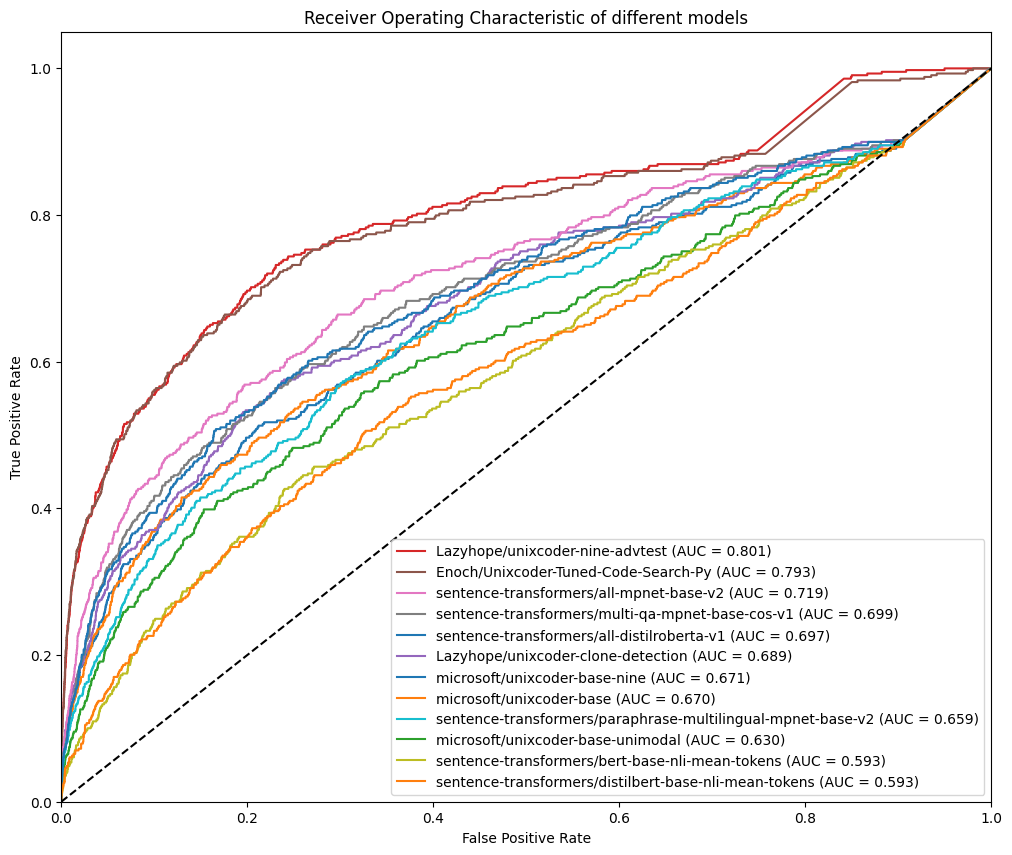

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


model_auc = {}
y_true = df['topic1'] == df['topic2']
fig = plt.figure(figsize=(12, 10))

def roc(model_name):
    y_score = df[model_name]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    model_auc[model_name] = roc_auc

    plt.plot(fpr, tpr, label=model_name)

for model in models:
    roc(model)

# Order labels by each model's auc score
handles, labels = plt.gca().get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: -model_auc[labels[k]])
ordered_handles = [handles[idx] for idx in order]
ordered_labels = [f'{labels[idx]} (AUC = {model_auc[labels[idx]]:.3f})' for idx in order]
plt.legend(ordered_handles, ordered_labels, loc="lower right")

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic of different models')
plt.savefig('roc_doc_evaluation_train_315.eps')
plt.show()

In [14]:
model_auc

{'microsoft/unixcoder-base-nine': 0.6711957795668481,
 'microsoft/unixcoder-base': 0.6696951249025659,
 'microsoft/unixcoder-base-unimodal': 0.6297370920734033,
 'Lazyhope/unixcoder-nine-advtest': 0.8005762510107144,
 'Lazyhope/unixcoder-clone-detection': 0.6893751823992921,
 'Enoch/Unixcoder-Tuned-Code-Search-Py': 0.7930968459055596,
 'sentence-transformers/all-mpnet-base-v2': 0.7189142633702663,
 'sentence-transformers/multi-qa-mpnet-base-cos-v1': 0.6985243403980401,
 'sentence-transformers/bert-base-nli-mean-tokens': 0.5927083597809336,
 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2': 0.6593272377142161,
 'sentence-transformers/all-distilroberta-v1': 0.6970607955799487,
 'sentence-transformers/distilbert-base-nli-mean-tokens': 0.5925942963331288}